Using XGBoost to predict individuals' ethnic breakdown using G25 coordinates of both modern and ancient DNA samples

In [1]:
require(rio)
require(tidyverse)
require(xgboost)
require(ggrepel)
require(cowplot)

Loading required package: xgboost


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: ggrepel

Loading required package: cowplot


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [284]:
bad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_BA.csv"))
iad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_IA.csv"))
mad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_MA.csv"))
mod = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/Global25_PCA_modern_scaled.txt"))

In [285]:
head(bad,1)
head(iad,1)
head(mad,1)
head(mod,1)

sample                 V2       V3       V4        V5       V6      
1 Aidonia_LBA.rel:AID002 0.126344 0.158423 -0.001131 -0.05814 0.026159
  V7        V8       V9        V10      ⋯ V17       V18      V19       V20     
1 -0.025937 -0.00188 -0.001154 0.002454 ⋯ -0.006364 0.008345 -0.001774 0.002514
  V21       V22       V23       V24      V25       V26     
1 -0.005002 -0.006114 -0.004575 0.000986 -0.001566 -0.00455

sample               V2       V3       V4      V5        V6       V7       
1 Albania_BA_IA:I14688 0.119514 0.160454 0.02225 -0.028101 0.024312 -0.017012
  V8      V9        V10       ⋯ V17       V18       V19      V20      V21      
1 0.00141 -0.001385 -0.001841 ⋯ -0.016176 -0.008736 0.003674 0.003645 -0.004502
  V22       V23      V24       V25      V26      
1 -0.013726 0.009645 -0.001849 0.011809 -0.011855

sample                  V2       V3       V4       V5        V6     
1 Albania_Medieval:I13839 0.125205 0.153345 0.016216 -0.036176 0.03139
  V7        V8 V9       V10      ⋯ V17      V18      V19      V20     
1 -0.013108 0  0.002077 0.007772 ⋯ -0.01074 0.008996 0.004307 0.006536
  V21       V22       V23      V24      V25       V26     
1 -0.016508 -0.007237 0.001113 0.005053 -0.001205 0.001676

sample           PC1     PC2      PC3       PC4       PC5       PC6     
1 Abazin:KCHE-1032 0.10927 0.072103 -0.023004 -0.016796 -0.028005 0.003347
  PC7      PC8       PC9       ⋯ PC16     PC17      PC18      PC19     
1 0.003055 -0.010384 -0.049904 ⋯ -0.01074 -0.001173 -0.004054 -0.006662
  PC20     PC21     PC22      PC23      PC24      PC25     
1 0.023386 0.004742 -0.000124 -0.000863 -0.010965 -0.001916

In [286]:
colnames(mod) = colnames(bad)
myptrna = "^.+(?=:)"
myptrnb = "^\\w+?_\\w+?(?=[_:\\.])"
mod = mod %>% mutate(sample = str_extract(sample,myptrna))
bad = bad %>% mutate(sample = str_extract(sample,myptrnb))
iad = iad %>% mutate(sample = str_extract(sample,myptrnb))
mad = mad %>% mutate(sample = str_extract(sample,myptrnb))

In [155]:
mod %>% count(sample,sort = TRUE) %>% head(20)

sample           n  
1  Dutch            166
2  Swedish          101
3  Greek_Crete      100
4  Irish             85
5  Danish            81
6  German            79
7  German_Erlangen   67
8  Lak               52
9  Moldovan          42
10 Polish            41
11 French_Alsace     40
12 French_Brittany   40
13 Norwegian         40
14 Mongol_IMAR       39
15 French_Occitanie  36
16 French_Nord       33
17 Karelian          33
18 Tunisian_Douz     33
19 Bashkir           31
20 Greek_Laconia     31

In [78]:
bad %>% count(sample,sort = TRUE) %>% head(10)

sample             n  
1  Czech_EBA          100
2  Poland_Trzciniec    66
3  Czech_CordedWare    41
4  Czech_BellBeaker    34
5  Armenia_LBA         30
6  England_BellBeaker  27
7  Serbia_Mokrin       27
8  Israel_MLBA         26
9  Sweden_Gotland      26
10 Turkey_EBA          26

In [79]:
iad %>% count(sample,sort = TRUE) %>% head(10)

sample                n  
1  England_MIA           122
2  Armenia_LBA            42
3  England_EIA            32
4  England_EastYorkshire  30
5  Mongolia_EIA           25
6  Czech_IA               23
7  Poland_Kowalewko       23
8  Kazakhstan_Tasmola     19
9  Iran_Hasanlu           18
10 Italy_Tuscany          18

In [80]:
mad %>% count(sample,sort = TRUE) %>% head(10)

sample                n  
1  Sweden_Viking         118
2  England_EarlyMedieval  89
3  Denmark_Viking         68
4  Italy_Medieval         38
5  Estonia_EarlyViking    34
6  Ireland_Kilteasheen    30
7  England_Viking         29
8  Vladimir_MA            28
9  Mongolia_Arkhangai     26
10 Norway_Viking          26

In [28]:
ppl = as_tibble(import("../Genetics/G25/Data/People/All.txt"))

In [17]:
ppl

V1        V2       V3       V4        V5        V6       V7        V8       
1 RN:RN2020 0.100164 0.135065 -0.003771 -0.041667 0.009540 -0.017570 -0.004465
2 TP:TP2022 0.127482 0.125926  0.072407  0.060724 0.033852  0.024821  0.010340
3 MN:MN2020 0.097888 0.141159 -0.002640 -0.051034 0.009540 -0.017012 -0.007285
4 MD:MD2022 0.099026 0.129988 -0.001886 -0.041667 0.011079 -0.015060  0.002350
  V9        V10       ⋯ V17       V18       V19       V20       V21      
1 -0.003000  0.008590 ⋯ -0.013657 -0.016168  0.003801  0.001508 -0.005378
2  0.006692 -0.005931 ⋯  0.007292  0.004955 -0.000380  0.004274  0.004877
3  0.000000  0.006954 ⋯ -0.005701 -0.017732  0.002660 -0.002388 -0.004002
4  0.001846  0.011862 ⋯ -0.003978  0.001956  0.000380 -0.000628 -0.005753
  V22       V23       V24       V25       V26      
1 -0.002870 -0.002226 -0.001109 -0.002771 -0.005987
2 -0.008610 -0.001978  0.006532 -0.006266 -0.001676
3  0.000749 -0.007048 -0.002095  0.003976 -0.000120
4 -0.006738 -0.001978 -0.001849 -0.001807 -0.008143

In [29]:
smpls = as_tibble(import("../Genetics/G25/Data/TXT/By Country/Averages/Modern_averages.txt"))

In [20]:
nrow(smpls)
smpls %>% sample_n(10)

[1] 48

V1                           V2        V3        V4         V5        
1  Lithuanian_VA:average        0.1344249 0.1257226  0.0824762  0.0750975
2  Ukrainian_Zhytomyr:average   0.1313841 0.1272314  0.0710604  0.0592936
3  Ashkenazi_Belarussia:average 0.1019155 0.1339716 -0.0073393 -0.0395799
4  Ashkenazi_Lithuania:average  0.0998539 0.1327575 -0.0092224 -0.0403750
5  Serbian:average              0.1273334 0.1372290  0.0400240  0.0148299
6  Cossack_Ukrainian:average    0.1354490 0.1167860  0.0716530  0.0600780
7  North_Ossetian:average       0.1041480 0.0888588 -0.0311125 -0.0251132
8  Ukrainian_Rivne:average      0.1301377 0.1243461  0.0702284  0.0625543
9  Ashkenazi_Ukraine:average    0.0994244 0.1351162 -0.0055060 -0.0401166
10 Polish:average               0.1318405 0.1292694  0.0698685  0.0577382
   V6         V7         V8         V9         V10        ⋯ V17       
1   0.0433311  0.0278890  0.0099878  0.0148840 -0.0020454 ⋯  0.0029435
2   0.0371497  0.0232674  0.0104747  0.0132521 -0.0029216 ⋯ -0.0041293
3   0.0107712 -0.0144595 -0.0010123 -0.0010294  0.0057267 ⋯  0.0027944
4   0.0094843 -0.0141475 -0.0005555 -0.0011750  0.0060613 ⋯  0.0034595
5   0.0314974  0.0045957  0.0048738  0.0066720 -0.0011737 ⋯ -0.0008358
6   0.0338520  0.0231480  0.0112810  0.0106150  0.0030680 ⋯  0.0019890
7  -0.0383148  0.0057170  0.0117505 -0.0006925 -0.0539945 ⋯ -0.0226065
8   0.0392208  0.0211027  0.0096616  0.0104867 -0.0003636 ⋯ -0.0009428
9   0.0120483 -0.0142652 -0.0010928  0.0001154  0.0077720 ⋯ -0.0018297
10  0.0406754  0.0217127  0.0086781  0.0108626 -0.0009329 ⋯ -0.0005595
   V18        V19        V20        V21        V22        V23        V24       
1   0.0061411 -0.0005702  0.0023129  0.0061155 -0.0037310 -0.0048100  0.0072346
2   0.0045820 -0.0006336  0.0036631  0.0006433 -0.0078433 -0.0031266  0.0046306
3   0.0018154 -0.0003409  0.0014889 -0.0012602 -0.0038586 -0.0007705  0.0027399
4   0.0016001  0.0001612  0.0004455 -0.0031721 -0.0032555 -0.0033497  0.0029245
5   0.0040476  0.0005894  0.0043011 -0.0024468 -0.0083168 -0.0017151  0.0048925
6   0.0003910  0.0051940  0.0035200  0.0033770 -0.0096080 -0.0023490  0.0040670
7   0.0027380 -0.0059542 -0.0098988  0.0188840  0.0060518  0.0019472 -0.0007395
8   0.0055342 -0.0017314  0.0032261 -0.0006670 -0.0049217 -0.0036958  0.0048341
9  -0.0043223 -0.0000190  0.0012758 -0.0046772 -0.0031258 -0.0025904  0.0007702
10  0.0015455 -0.0000741  0.0026948  0.0012872 -0.0031286 -0.0031185  0.0056063
   V25        V26       
1  -0.0078805 -0.0008622
2  -0.0027714  0.0019331
3   0.0015665 -0.0002949
4   0.0024428 -0.0010560
5   0.0003720 -0.0020097
6  -0.0068680  0.0005990
7  -0.0084048 -0.0027242
8  -0.0043109  0.0001066
9   0.0021028  0.0010059
10 -0.0033328 -0.0000876

In [22]:
myfun = function (mydf,e = 0.75,d = 5,a = 0.5,g = 0,l = 0.5) {
        mydata = mydf %>% mutate(label = as.numeric(as.factor(sample)) - 1) %>% select(-sample)
        nclas = length(unique(mydata$label))
        print(paste0("Number of classes: ",nclas))
        smpl = sample(1:nrow(mydata),.75*nrow(mydata))
        print("Split into test and train samples")
        train_data = mydata[smpl,]
        test_data = mydata[-smpl,]
        print(dim(train_data))
        print(dim(test_data))
        td = data.matrix(train_data %>% select(-label))
        tl = train_data$label
        ttd = data.matrix(test_data %>% select(-label))
        ttl = test_data$label
        dtrain = xgb.DMatrix(data = td,label = tl)
        dtest = xgb.DMatrix(data = ttd,label = ttl)
        print("Starting XGBoost training")
        obj = "multi:softprob"
        mymod = xgb.train(data = dtrain,
                          eta = e,
                          max_depth = d,
                          nround = 100,
                          subsample = .5,
                          colsample_bytree = .5,
                          alpha = a,
                          gamma = g,
                          lambda = l,
                          objective = obj,
                          num_class = nclas,
                          nthread = 4,
                          watchlist = list(train = dtrain,test = dtest),
                          print_every_n = 25,
                          verbose = 1)
        mypred = predict(mymod,dtest)
        nclas = ifelse(str_ends(obj,"max"),1,nclas)
        mypred = mypred %>% matrix(ncol = nclas,byrow = TRUE) %>% as_tibble() %>% mutate(row = row_number()) %>% bind_cols(label = ttl)
        colnames(mypred) = c(as.character(0:(nclas-1)),"row","label")
        myd = pivot_longer(mypred,cols = !matches("^[rl]"),names_to = "variable",values_to = "value")
        myd = myd %>% group_by(row,label) %>% mutate(maxval = max(value)) %>% ungroup()
        mydd = myd %>% dplyr::filter(value == maxval)
        print(sample_n(mydd,15))
        err = with(mydd,mean(label != variable))
        print(paste0("test-error = ", err))
        return(mymod)
    }

In [171]:
mypfun = function(mymdl,mypd,mynd,verbose = TRUE) {
    smpls = unique(na.omit(mypd$sample))
    #nclas = 1
    nclas = length(smpls)
    print(paste0("Using ",nclas," populations"))
    mypred = predict(mymdl,xgb.DMatrix(data = data.matrix(mynd %>% select(-V1)),label = 1:nrow(mynd)))
    mypred = mypred %>% matrix(ncol = nclas,byrow = TRUE) %>% as_tibble() %>% mutate(row = row_number())
    colnames(mypred) = c(as.character(0:(nclas-1)),"row")
    myd = pivot_longer(mypred,cols = !matches("^row"),names_to = "variable",values_to = "value")
#    myd = myd %>% group_by(row) %>% mutate(tot = sum(value)) %>% mutate(value = value/tot) %>% ungroup() 
    mprd = myd %>% inner_join(mynd %>% select(V1) %>% mutate(row = row_number()),by = "row") %>% 
            inner_join(data.frame(variable = as.character(1:length(smpls)),eth = smpls))
    mprd = mprd %>% mutate(name = str_extract(V1,"^.+(?=:)")) %>% select(name,eth,value)
    if(verbose) print(mprd %>% dplyr::filter(value >= 0.02) %>% 
                          mutate(value = paste0(round(100*value,2),"%")) %>% 
                          arrange(name,desc(value)) %>% as.data.frame)
    return(mprd)
}

In [177]:
mypfun2 = function(mymdl,mypd,mynd) {
    mprd = mypfun(mymdl,mypd,mynd,verbose = FALSE)
    for(ii in 1:999) {
        mprd = bind_rows(mprd,mypfun(mymdl,mypd,mynd,verbose = FALSE))
    }
    mprd = mprd %>% group_by(name,eth) %>% summarize(value = round(100*mean(value))) %>% 
                    arrange(name,desc(value)) %>% dplyr::filter(value >= 2)
    return(mprd)
    }

In [166]:
mythm = theme_minimal_hgrid(7,color = "gray45",line_size = 0.1) + theme(plot.background = element_rect(fill = "gray20"))

In [167]:
plotfun = function(mydata,lsz = 2,nrw = 1) {
    ggplot(mydata,aes(as.numeric(str_remove(value,"%")),I(1))) + 
        geom_label_repel(stat = "identity",aes(label = eth,fill = as.numeric(as.factor(name))),size = lsz,force = 4) + 
        scale_x_log10() + 
        facet_wrap(facets = ~ name,nrow = nrw) + 
        #coord_cartesian(ylim = c(3,8)) + 
        coord_flip() + 
        guides(fill = "none") + 
        scale_fill_distiller() + 
        #scale_fill_viridis_c(option = "H") + 
        mythm + xlab("%") + ylab("") + 
        theme(axis.text.x = element_blank(),axis.line.x = element_blank(),axis.ticks.x = element_blank())
    }

In [168]:
plotfun2 = function(mydata,nrw = 1) {
    ggplot(mydata,aes(reorder(eth,value),value)) + 
        geom_bar(aes(fill = value),stat = "identity") + 
        facet_wrap(~ name,nrow = nrw) + 
        scale_fill_viridis_c("G") + 
        coord_flip() + xlab("") + ylab("") + 
        mythm + guides(fill = "none") + 
        theme(axis.text = element_text(size = 4,color = "wheat"))
    }

In [224]:
plotfun3 = function(mprd) {
    p1 = plotfun(mprd,lsz = 1.5)
    p2 = plotfun2(mprd)
    options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 400)
    plot_grid(p1,p2,labels = c('A','B'),label_size = 10)
    }

Modern Populations

In [287]:
mdl = myfun(na.omit(mod),e = 0.5,a = 1,l = 10)

[1] "Number of classes: 391"
[1] "Split into test and train samples"
[1] 3582   26
[1] 1194   26
[1] "Starting XGBoost training"
[1]	train-mlogloss:5.537399	test-mlogloss:5.584334 
[26]	train-mlogloss:2.314773	test-mlogloss:3.408938 
[51]	train-mlogloss:1.477313	test-mlogloss:3.049051 
[76]	train-mlogloss:1.096387	test-mlogloss:2.913518 
[100]	train-mlogloss:0.900769	test-mlogloss:2.862833 
# A tibble: 15 × 5
     row label variable  value maxval
   <int> <dbl> <chr>     <dbl>  <dbl>
 1   238    82 82       0.617  0.617 
 2  1023   334 317      0.0879 0.0879
 3   981   311 47       0.204  0.204 
 4   147    55 56       0.382  0.382 
 5   298    91 236      0.0383 0.0383
 6   975   306 28       0.604  0.604 
 7   814   248 9        0.475  0.475 
 8   720   217 168      0.0776 0.0776
 9   759   230 230      0.197  0.197 
10  1058   342 342      0.918  0.918 
11   648   190 190      0.452  0.452 
12   105    43 39       0.134  0.134 
13   882   271 91       0.0270 0.0270
14    31    12 12

In [288]:
mprd = mypfun(mdl,mod,ppl)

[1] "Using 391 populations"


Joining with `by = join_by(variable)`


   name                   eth  value
1    MD      Ashkenazi_Poland  6.93%
2    MD   Ashkenazi_Lithuania  6.08%
3    MD         Armenian_Urfa  3.58%
4    MD      Ashkenazi_Russia 29.79%
5    MD     Ashkenazi_Germany   2.1%
6    MN   Ashkenazi_Lithuania 71.82%
7    MN  Ashkenazi_Belarussia  2.83%
8    RN   Ashkenazi_Lithuania 48.98%
9    RN      Ashkenazi_Russia 31.07%
10   RN      Ashkenazi_Poland  2.01%
11   TP   Russian_Leshukonsky  9.94%
12   TP Ukrainian_Zakarpattia  9.69%
13   TP        Russian_Ryazan  6.68%
14   TP       Ukrainian_Rivne   3.1%
15   TP                Bedzan  2.59%
16   TP   Ukrainian_Chernihiv  2.27%
17   TP        Ukrainian_Lviv  2.12%


In [289]:
mprd = mypfun2(mdl,mod,ppl)

[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`


[1] "Using 391 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


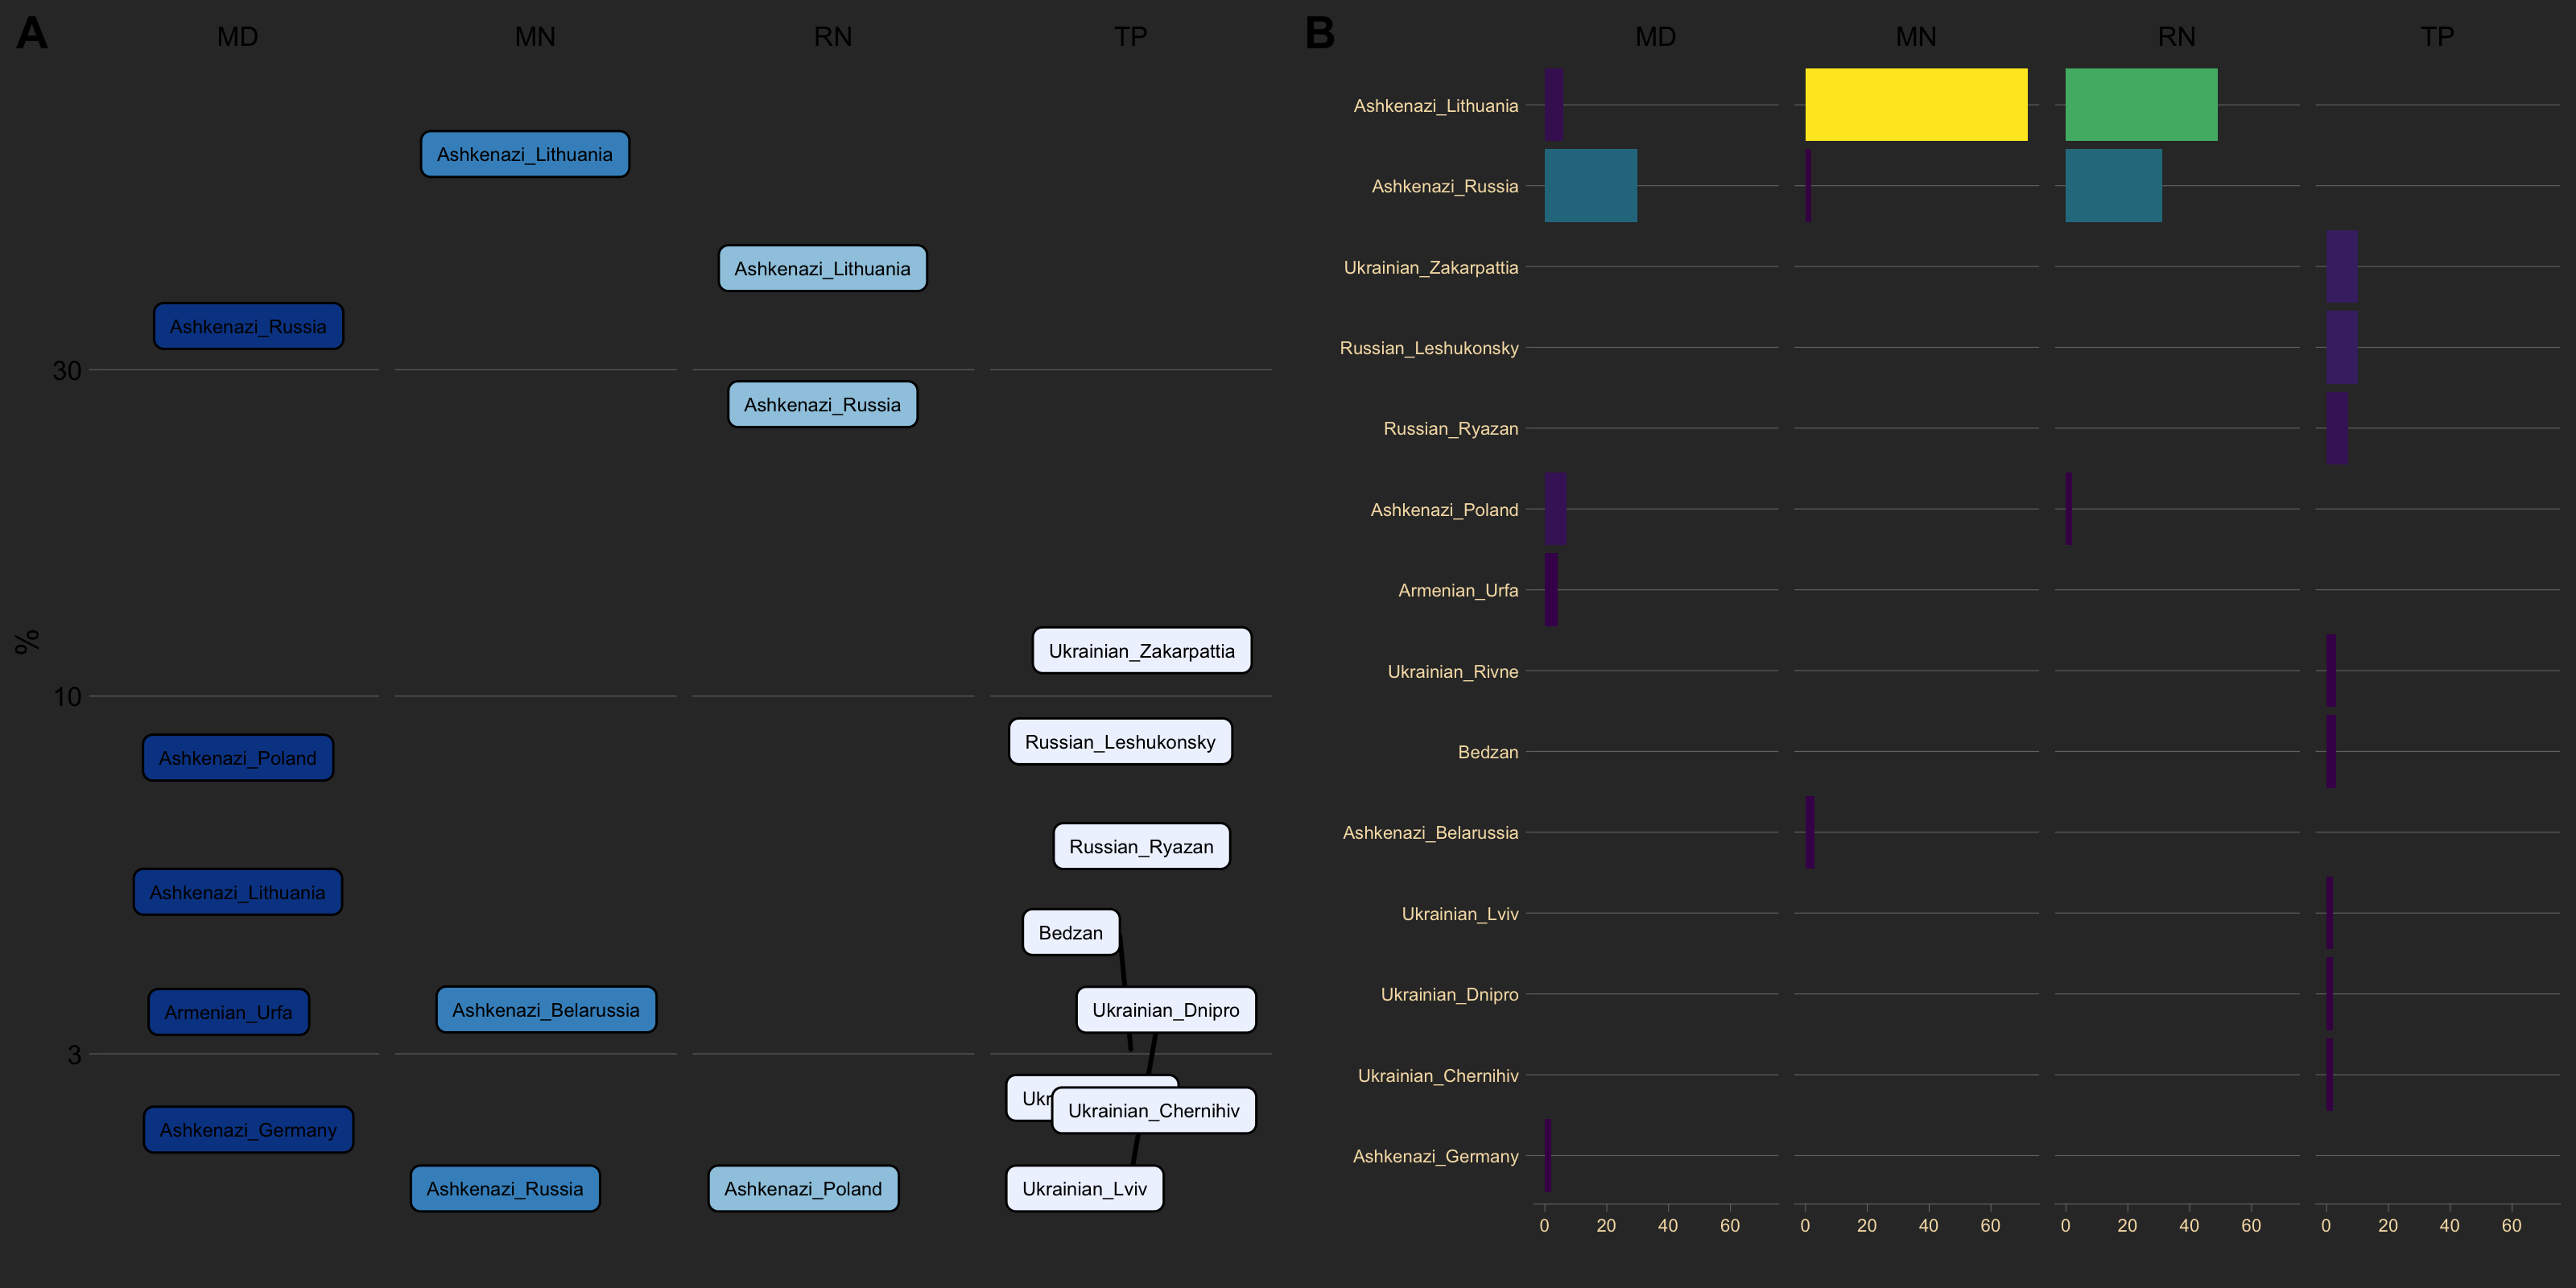

In [290]:
plotfun3(mprd)

In [291]:
#mod = mod %>% mutate(sample = ifelse(str_detect(sample,"_"),str_extract(sample,"^\\w+?(?=_)"),sample))
#modd = mod %>% mutate(sample = ifelse(str_detect(sample,"Ukrain|Lithuan|Ashken|Italian|Spani|Greek|Georgi|Irani|Turki|Frenc|Azerb|Armeni|Basqu"),str_extract(sample,"^\\w+?(?=_)"),sample))
#modd = mod %>% mutate(sample = ifelse(str_detect(sample,"Ukrain|Lithuan|Ashken|Georgi|Azerb|Armeni|Basqu"),str_extract(sample,"^\\w+?(?=_)"),sample))
modd = mod %>% dplyr::filter(!str_detect(sample,"^(Elmo|Tat|Roma|Alta|Aeta|Bata|Erit|Mongo|Saami|Shor|Satna)")) %>% na.omit()
mdl = myfun(modd,e = 0.5,a = 1,l = 10)

[1] "Number of classes: 357"
[1] "Split into test and train samples"
[1] 3361   26
[1] 1121   26
[1] "Starting XGBoost training"
[1]	train-mlogloss:5.457783	test-mlogloss:5.533315 
[26]	train-mlogloss:2.260892	test-mlogloss:3.340530 
[51]	train-mlogloss:1.439845	test-mlogloss:2.993087 
[76]	train-mlogloss:1.067836	test-mlogloss:2.872749 
[100]	train-mlogloss:0.868774	test-mlogloss:2.809086 
# A tibble: 15 × 5
     row label variable  value maxval
   <int> <dbl> <chr>     <dbl>  <dbl>
 1   257    79 79       0.504  0.504 
 2    97    32 7        0.100  0.100 
 3   572   173 241      0.0866 0.0866
 4   368   104 180      0.317  0.317 
 5   338    97 97       0.350  0.350 
 6   571   173 174      0.171  0.171 
 7    79    28 28       0.530  0.530 
 8   116    41 38       0.397  0.397 
 9   659   196 180      0.323  0.323 
10    24     8 8        0.278  0.278 
11    83    28 28       0.291  0.291 
12  1100   351 351      0.265  0.265 
13   799   232 232      0.186  0.186 
14   447   131 15

In [292]:
modd$sample %>% unique %>% sort

[1] "\\Albanian"                           
  [2] "Abazin"                               
  [3] "Abkhasian"                            
  [4] "Abkhasian_Gudauta"                    
  [5] "Adygei"                               
  [6] "Afrikaner"                            
  [7] "Albanian"                             
  [8] "Alevi_Dersim"                         
  [9] "Algerian"                             
 [10] "Armenian_Aintab"                      
 [11] "Armenian_Ararat"                      
 [12] "Armenian_Artsakh"                     
 [13] "Armenian_Erzurum"                     
 [14] "Armenian_Gesaria"                     
 [15] "Armenian_Gurin"                       
 [16] "Armenian_Hemsheni"                    
 [17] "Armenian_Parspatunik"                 
 [18] "Armenian_Syunik"                      
 [19] "Armenian_Urfa"                        
 [20] "Ashkenazi_Belarussia"                 
 [21] "Ashkenazi_Germany"                    
 [22] "Ashkenazi_Lithuania"                  
 [23] "Ashkenazi_Poland"                     
 [24] "Ashkenazi_Russia"                     
 [25] "Ashkenazi_Ukraine"                    
 [26] "Assyrian"                             
 [27] "Austrian"                             
 [28] "Avar"                                 
 [29] "Azerbaijani_Dagestan"                 
 [30] "Azerbaijani_Iran"                     
 [31] "Azerbaijani_Republic"                 
 [32] "Azerbaijani_Republic_Gabala"          
 [33] "Azerbaijani_Republic_Shaki"           
 [34] "Azerbaijani_Turkey"                   
 [35] "Bashkir"                              
 [36] "Basque_Araba"                         
 [37] "Basque_Baztan"                        
 [38] "Basque_Biscay"                        
 [39] "Basque_French"                        
 [40] "Basque_Gipuzkoa"                      
 [41] "Basque_Gipuzkoa_Southwest"            
 [42] "Basque_Lower_Navarre"                 
 [43] "Basque_Navarre_Center"                
 [44] "Basque_Navarre_North"                 
 [45] "Basque_Roncal"                        
 [46] "Basque_Soule"                         
 [47] "Basque_Spanish"                       
 [48] "BedouinA"                             
 [49] "BedouinB"                             
 [50] "Bedzan"                               
 [51] "Belarusian"                           
 [52] "BelgianA"                             
 [53] "BelgianB"                             
 [54] "BelgianC"                             
 [55] "Berber_Algeria"                       
 [56] "Berber_MAR_ERR"                       
 [57] "Berber_MAR_TIZ"                       
 [58] "Berber_Tunisia_Chen"                  
 [59] "Berber_Tunisia_Sen"                   
 [60] "Bosnian"                              
 [61] "Bukharian_Jew"                        
 [62] "Bulgarian"                            
 [63] "Buryat"                               
 [64] "Chechen"                              
 [65] "Chenchu"                              
 [66] "Cherkes"                              
 [67] "Chuvash"                              
 [68] "Circassian"                           
 [69] "Cochin_Jew_A"                         
 [70] "Cochin_Jew_B"                         
 [71] "Cossack_Kuban"                        
 [72] "Cossack_Ukrainian"                    
 [73] "Croatian"                             
 [74] "Cypriot"                              
 [75] "Czech"                                
 [76] "Danish"                               
 [77] "Darginian"                            
 [78] "Druze"                                
 [79] "Dungan"                               
 [80] "Dutch"                                
 [81] "Egyptian"                             
 [82] "EmiratiA"                             
 [83] "EmiratiB"                             
 [84] "EmiratiC"                             
 [85] "English"                              
 [86] "English_Cornwall"                     
 [87] "Erzya"                                


In [293]:
mprd = mypfun(mdl,modd,ppl)

[1] "Using 357 populations"


Joining with `by = join_by(variable)`


   name                   eth  value
1    MD      Ashkenazi_Poland  5.04%
2    MD      Ashkenazi_Russia 37.66%
3    MD         Armenian_Urfa  3.77%
4    MD   Ashkenazi_Lithuania 10.94%
5    MN      Ashkenazi_Russia   7.5%
6    MN   Ashkenazi_Lithuania 55.13%
7    MN  Ashkenazi_Belarussia  3.26%
8    RN   Ashkenazi_Lithuania  45.6%
9    RN      Ashkenazi_Russia 28.44%
10   TP Ukrainian_Zakarpattia  5.53%
11   TP   Russian_Leshukonsky  4.51%
12   TP               Cypriot  3.48%
13   TP        Russian_Ryazan  3.26%
14   TP           Palestinian  2.51%
15   TP       Ukrainian_Rivne  2.33%


In [294]:
mprd = mypfun2(mdl,modd,ppl)

[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`


[1] "Using 357 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


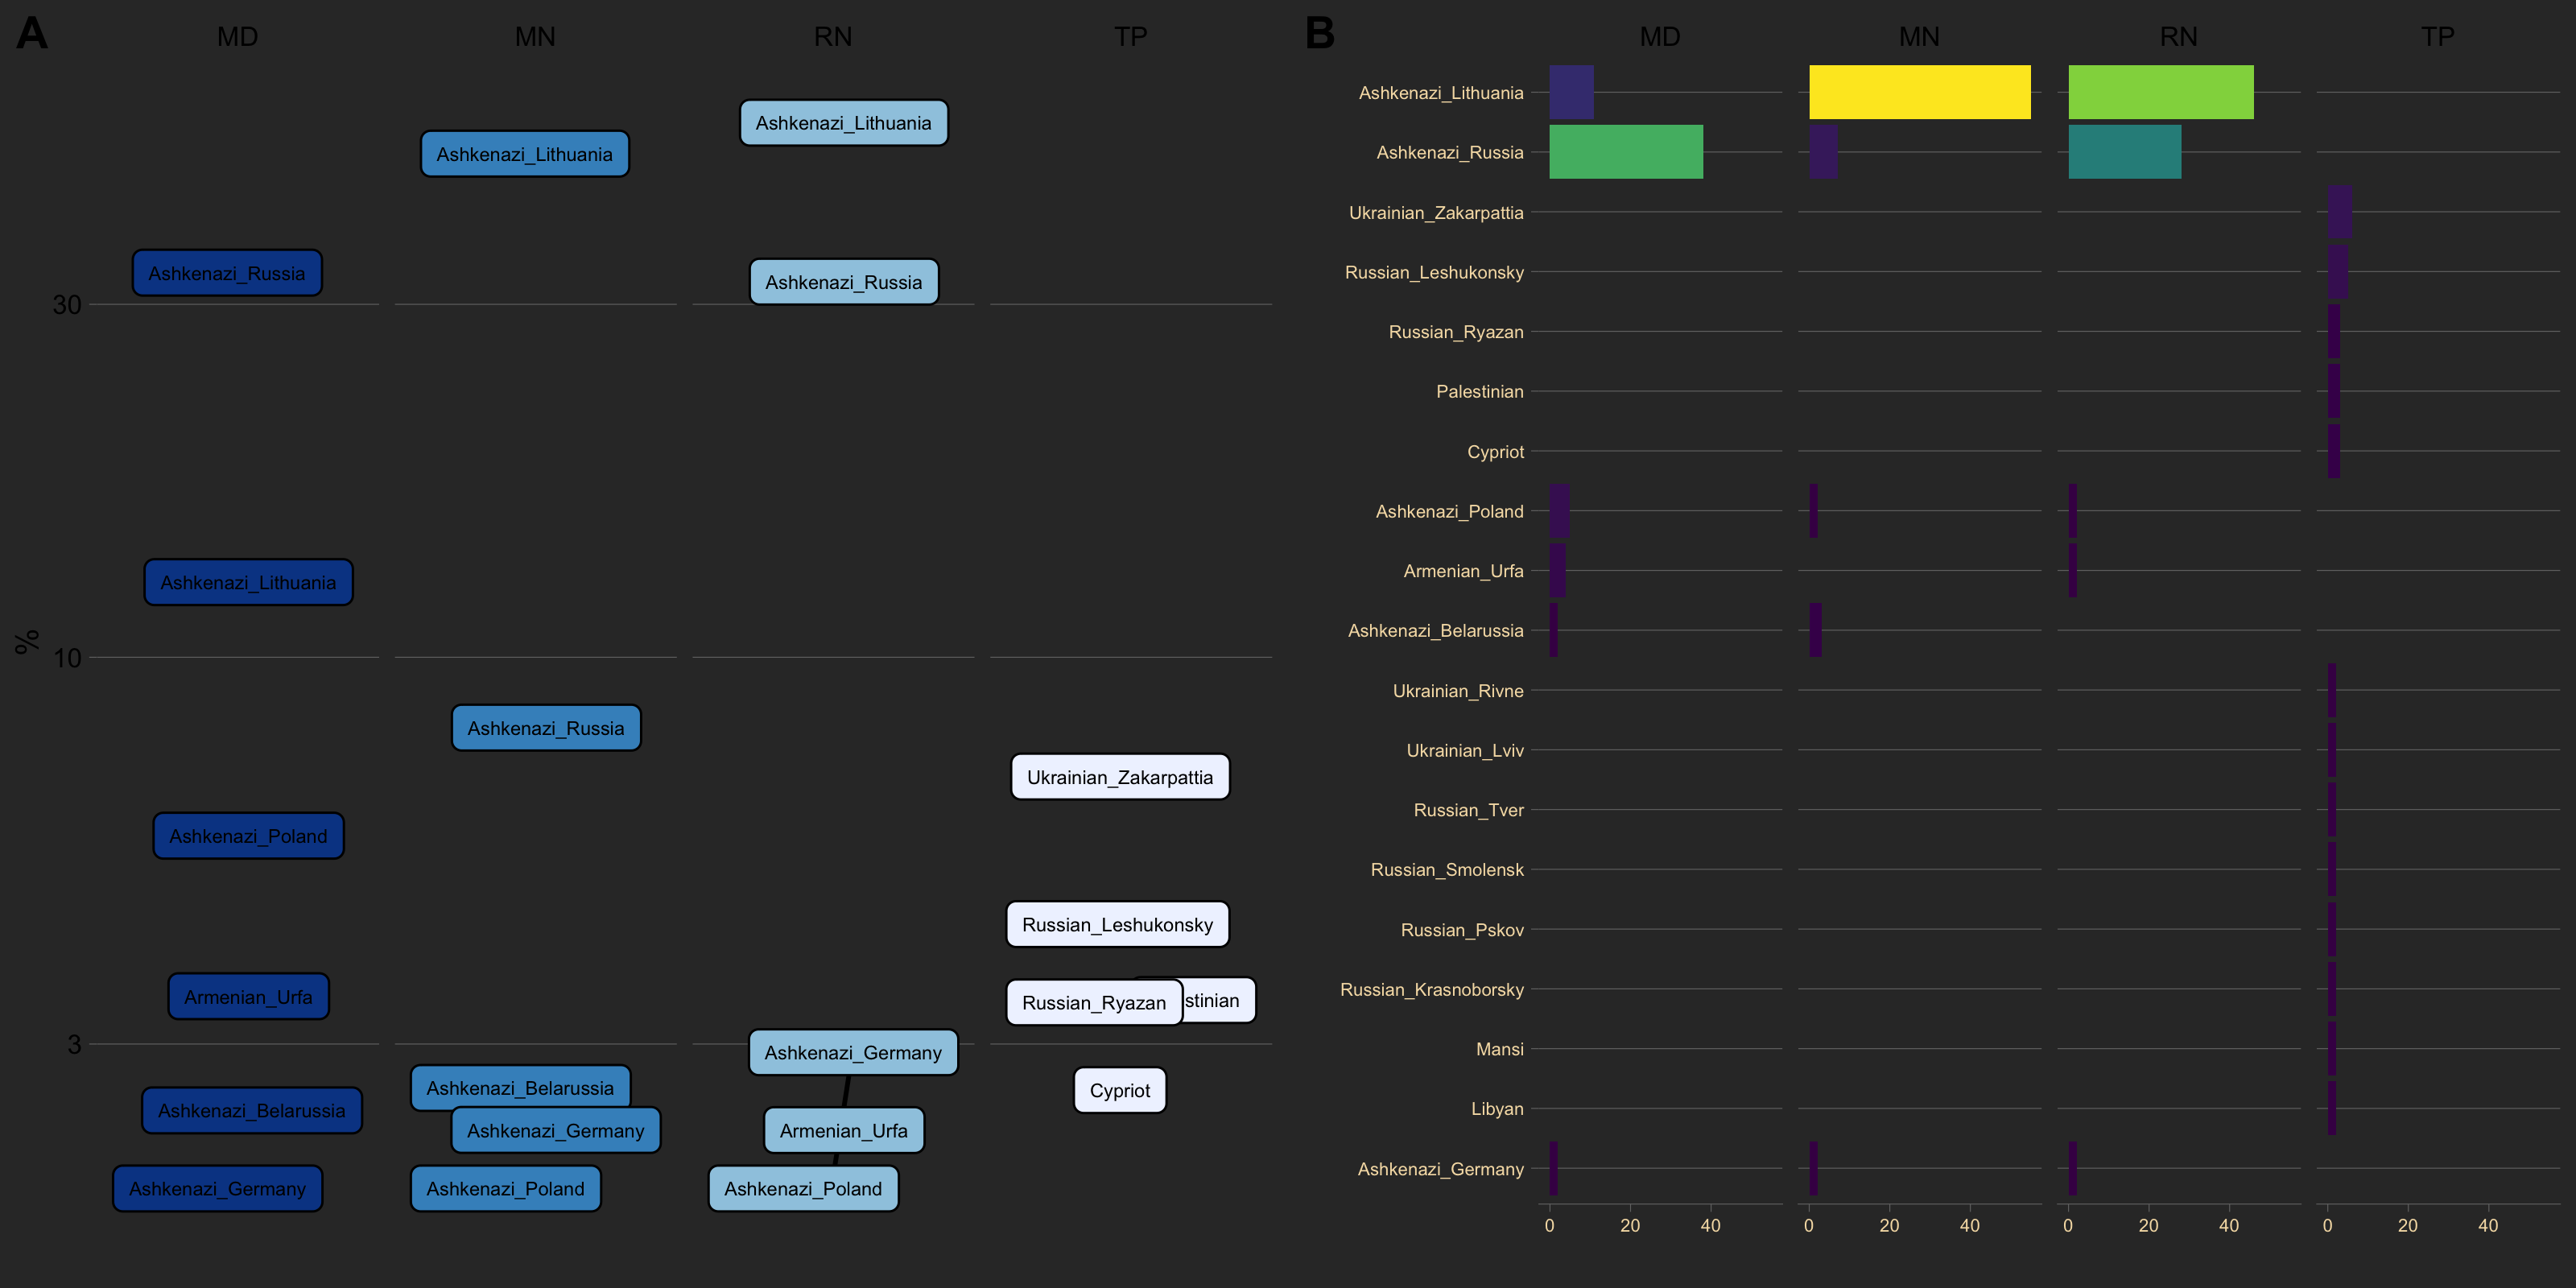

In [295]:
plotfun3(mprd)

Bronze Age

In [296]:
mdl = myfun(na.omit(bad),e = 1,a = 1,l = 10)

[1] "Number of classes: 233"
[1] "Split into test and train samples"
[1] 1068   26
[1] 357  26
[1] "Starting XGBoost training"
[1]	train-mlogloss:4.909506	test-mlogloss:4.935734 
[26]	train-mlogloss:2.258924	test-mlogloss:3.350156 
[51]	train-mlogloss:1.755150	test-mlogloss:3.263681 
[76]	train-mlogloss:1.526543	test-mlogloss:3.258402 
[100]	train-mlogloss:1.389339	test-mlogloss:3.234205 
# A tibble: 15 × 5
     row label variable  value maxval
   <int> <dbl> <chr>     <dbl>  <dbl>
 1    86    31 27       0.605  0.605 
 2   127    57 177      0.316  0.316 
 3   167    95 166      0.0758 0.0758
 4    13    11 132      0.0482 0.0482
 5    44    26 26       0.0758 0.0758
 6   253   165 87       0.248  0.248 
 7    99    32 27       0.768  0.768 
 8   242   158 161      0.0912 0.0912
 9   328   208 210      0.194  0.194 
10    69    27 27       0.935  0.935 
11    60    27 27       0.453  0.453 
12   209   137 137      0.977  0.977 
13   282   182 182      0.105  0.105 
14   181   115 163 

In [297]:
mprd = mypfun(mdl,bad,ppl)

[1] "Using 233 populations"


Joining with `by = join_by(variable)`


  name              eth  value
1   TP Czech_CordedWare 77.29%
2   TP       Poland_TRB 13.86%


In [298]:
mprd = mypfun2(mdl,bad,ppl)

[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`


[1] "Using 233 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


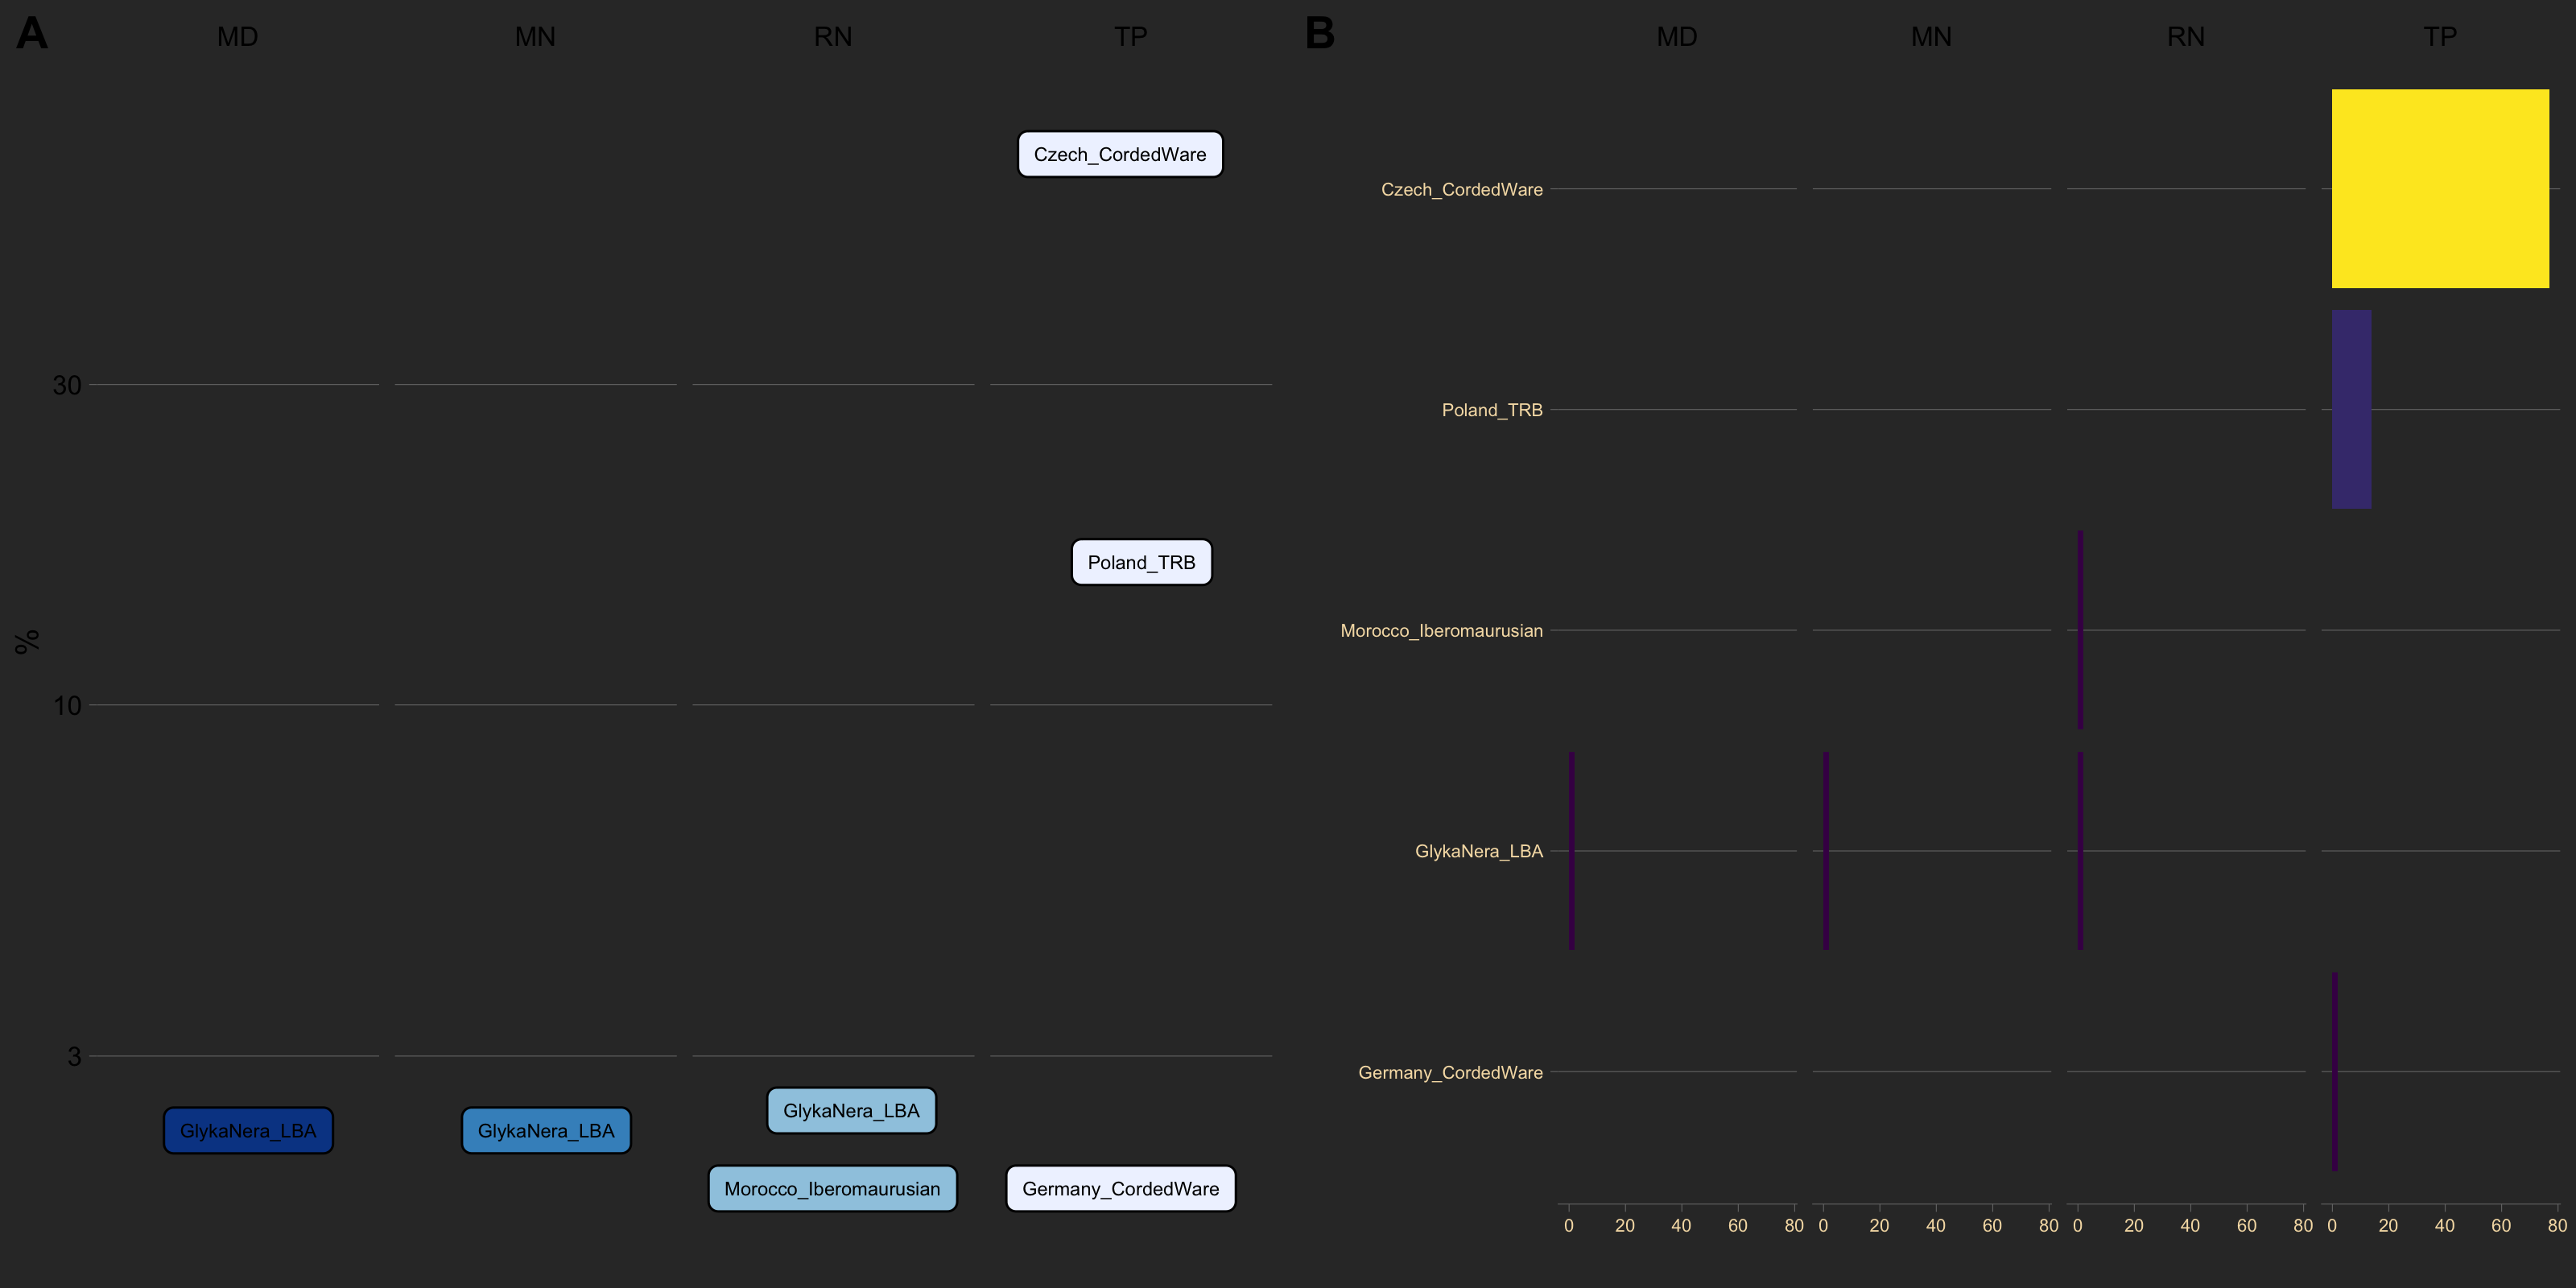

In [299]:
plotfun3(mprd)

In [60]:
mprd = mypfun(mdl,bad,smpls)

[1] "Using 225 populations"


Joining with `by = join_by(variable)`


                     name                     eth value
1    Ashkenazi_Belarussia     Bulgaria_BeliBreyag  4.8%
2    Ashkenazi_Belarussia             Lebanon_MBA  2.3%
3    Ashkenazi_Belarussia             Hungary_MBA  1.5%
4    Ashkenazi_Belarussia Ukraine_GlobularAmphora  1.4%
5    Ashkenazi_Belarussia             Armenia_MBA  1.2%
6     Ashkenazi_Lithuania             Lebanon_MBA  2.2%
7     Ashkenazi_Lithuania        Armenia_Lchashen  1.6%
8     Ashkenazi_Lithuania             Hungary_MBA  1.6%
9     Ashkenazi_Lithuania     Bulgaria_BeliBreyag  1.5%
10    Ashkenazi_Lithuania Ukraine_GlobularAmphora  1.4%
11    Ashkenazi_Lithuania      Slovakia_Mikusovce  1.3%
12    Ashkenazi_Lithuania             Armenia_MBA  1.2%
13    Ashkenazi_Lithuania            Iran_Hasanlu  1.1%
14      Ashkenazi_Ukraine             Lebanon_MBA  2.2%
15      Ashkenazi_Ukraine        Armenia_Lchashen  1.9%
16      Ashkenazi_Ukraine     Bulgaria_BeliBreyag  1.8%
17      Ashkenazi_Ukraine             Hungary_MB

In [61]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 400)

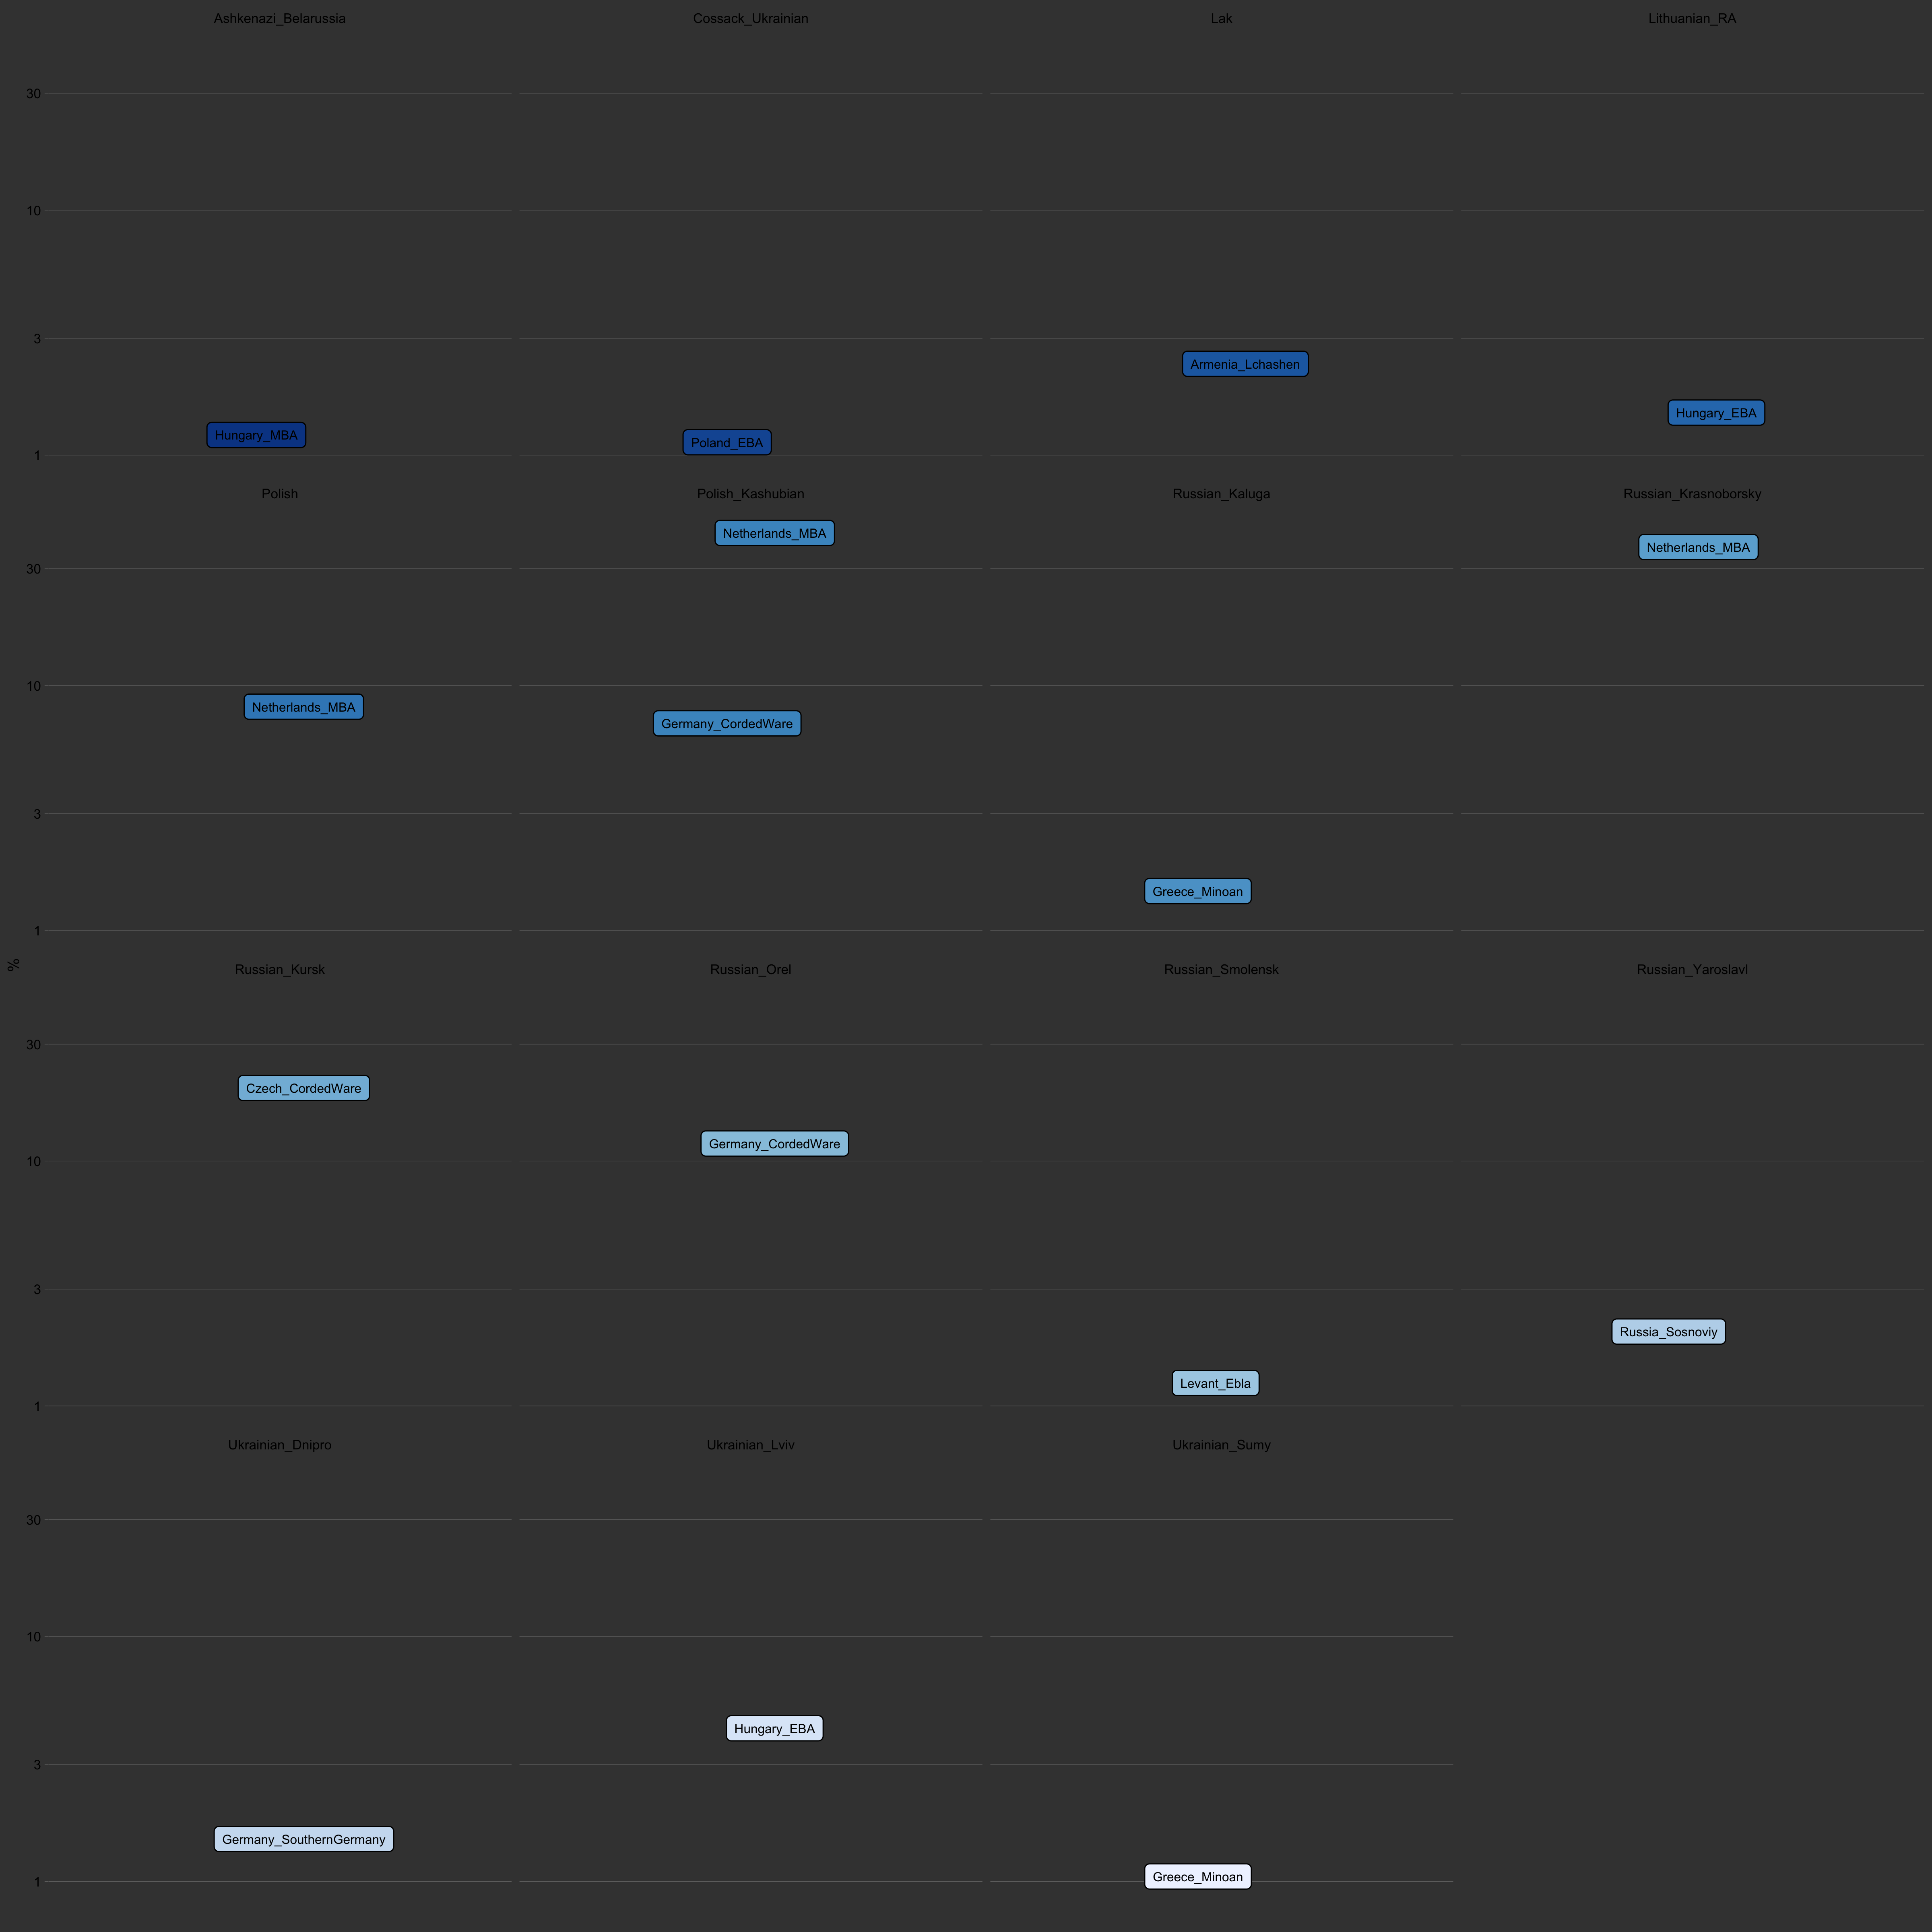

In [62]:
plotfun(mprd %>% sample_n(16),lsz = 2,nrw = 4)

IronAge

In [300]:
mdl = myfun(na.omit(iad),e = 0.5,a = 1,l = 10)

[1] "Number of classes: 129"
[1] "Split into test and train samples"
[1] 591  26
[1] 197  26
[1] "Starting XGBoost training"
[1]	train-mlogloss:4.496463	test-mlogloss:4.464959 
[26]	train-mlogloss:2.439974	test-mlogloss:2.992633 
[51]	train-mlogloss:1.889101	test-mlogloss:2.780811 
[76]	train-mlogloss:1.621736	test-mlogloss:2.710373 
[100]	train-mlogloss:1.464849	test-mlogloss:2.673704 
# A tibble: 15 × 5
     row label variable value maxval
   <int> <dbl> <chr>    <dbl>  <dbl>
 1    94    26 26       0.933  0.933
 2    73    26 26       0.614  0.614
 3    46    23 26       0.596  0.596
 4   125    49 58       0.273  0.273
 5   158    88 88       0.333  0.333
 6   196   127 107      0.249  0.249
 7   150    76 76       0.824  0.824
 8   162    92 92       0.503  0.503
 9    99    30 14       0.116  0.116
10   105    35 107      0.424  0.424
11   183   117 17       0.101  0.101
12   181   110 44       0.189  0.189
13    12     7 7        0.803  0.803
14    85    26 26       0.928  0.928

In [301]:
mprd = mypfun(mdl,iad,ppl)

[1] "Using 129 populations"


Joining with `by = join_by(variable)`


   name                   eth  value
1    MD        Italy_Sardinia  6.01%
2    MD          Iran_Hasanlu  2.48%
3    MD         Greece_Delphi  2.16%
4    MN  France_LesMarmousets     4%
5    MN          Iran_Hasanlu   2.8%
6    MN        Italy_Sardinia   2.4%
7    MN    ChannelIslands_EIA  2.19%
8    MN           Slovakia_IA  2.02%
9    RN        Italy_Sardinia  3.99%
10   RN  France_LesMarmousets  2.93%
11   RN Slovakia_BytcaHrabove  2.88%
12   RN          Iran_Hasanlu  2.47%
13   TP           Hungary_EIA  9.03%
14   TP      Poland_Kowalewko   8.7%
15   TP           Croatia_LIA  6.21%
16   TP             Norway_IA  4.96%
17   TP          Poland_Gaski  3.69%
18   TP      Poland_Maslomecz  2.69%
19   TP Slovakia_BytcaHrabove 12.26%


In [302]:
mprd = mypfun2(mdl,iad,ppl)

[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`


[1] "Using 129 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


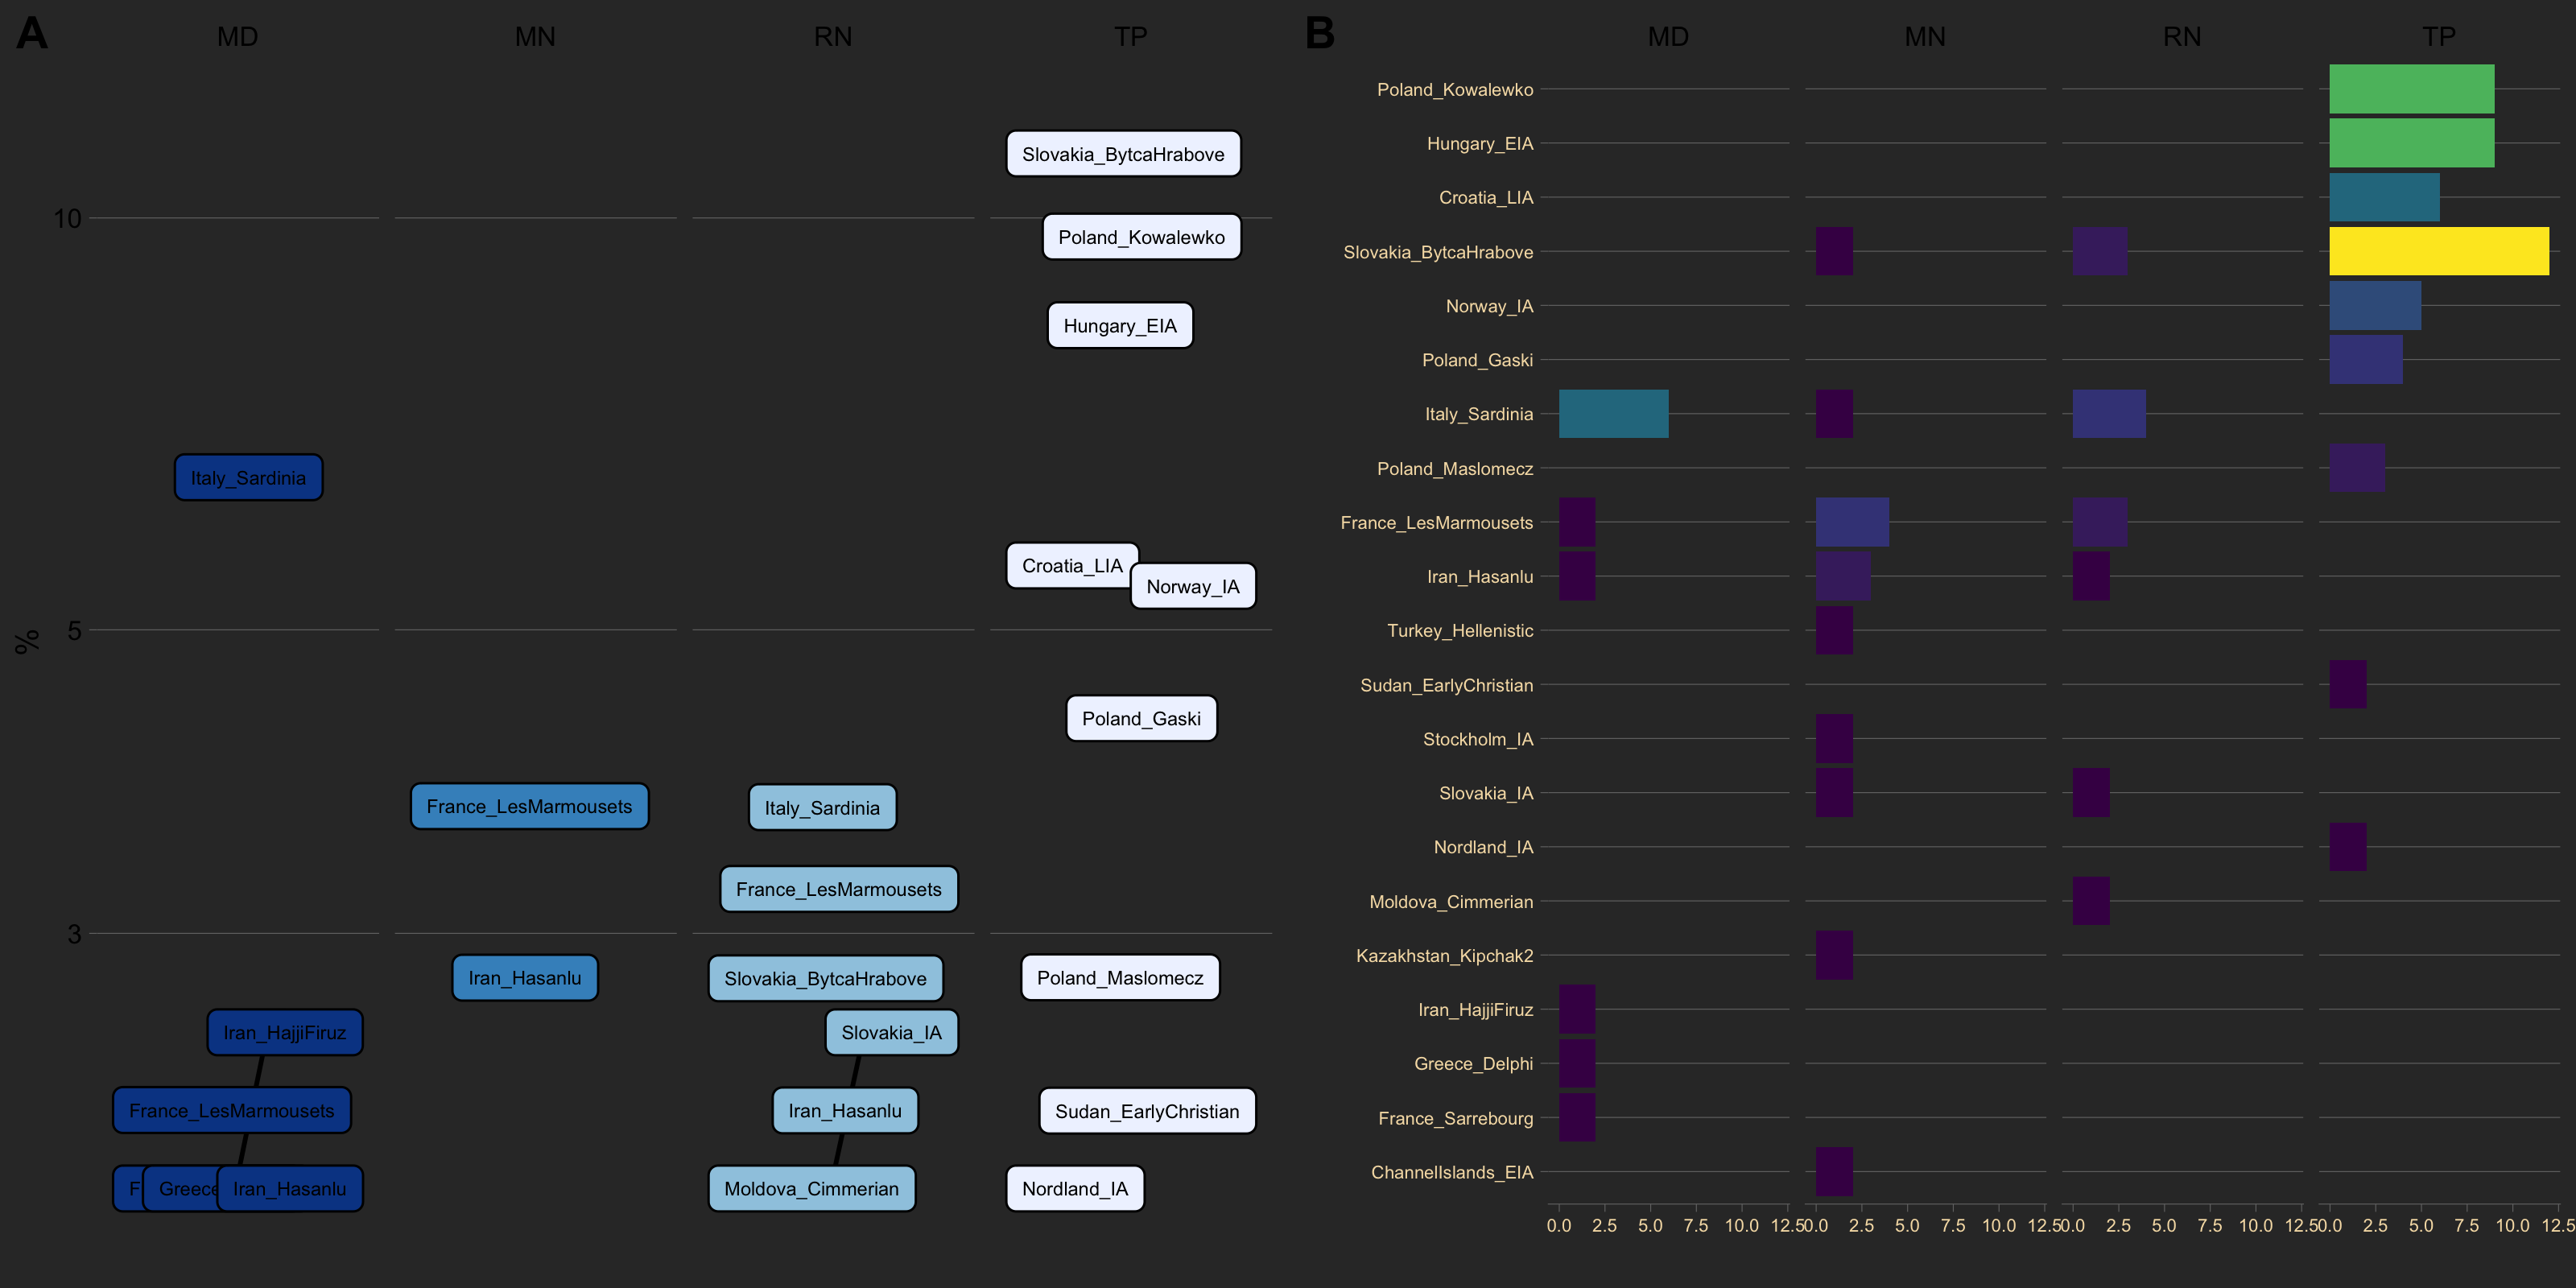

In [303]:
plotfun3(mprd)

In [67]:
mprd = mypfun(mdl,iad,smpls)

[1] "Using 124 populations"


Joining with `by = join_by(variable)`


                     name                           eth value
1    Ashkenazi_Belarussia                   Armenia_LBA  1.4%
2    Ashkenazi_Belarussia                 Italy_Tuscany  1.4%
3    Ashkenazi_Belarussia                  Iran_Hasanlu  1.4%
4    Ashkenazi_Belarussia                   Slovakia_IA  1.3%
5    Ashkenazi_Belarussia          France_LesMarmousets  1.3%
6    Ashkenazi_Belarussia                   Italy_Lazio  1.2%
7    Ashkenazi_Belarussia           Kyrgyzstan_TianShan  1.1%
8    Ashkenazi_Belarussia             Moldova_Cimmerian  1.1%
9    Ashkenazi_Belarussia              Kazakstan_Sargat  1.1%
10   Ashkenazi_Belarussia                     Spain_EIA  1.1%
11   Ashkenazi_Belarussia                     Israel_IA    1%
12   Ashkenazi_Belarussia               Iran_HajjiFiruz    1%
13   Ashkenazi_Belarussia                 Montenegro_IA    1%
14   Ashkenazi_Belarussia                  Scotland_MIA    1%
15   Ashkenazi_Belarussia                  Mongolia_Uvs    1%
16   Ash

In [204]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 400)

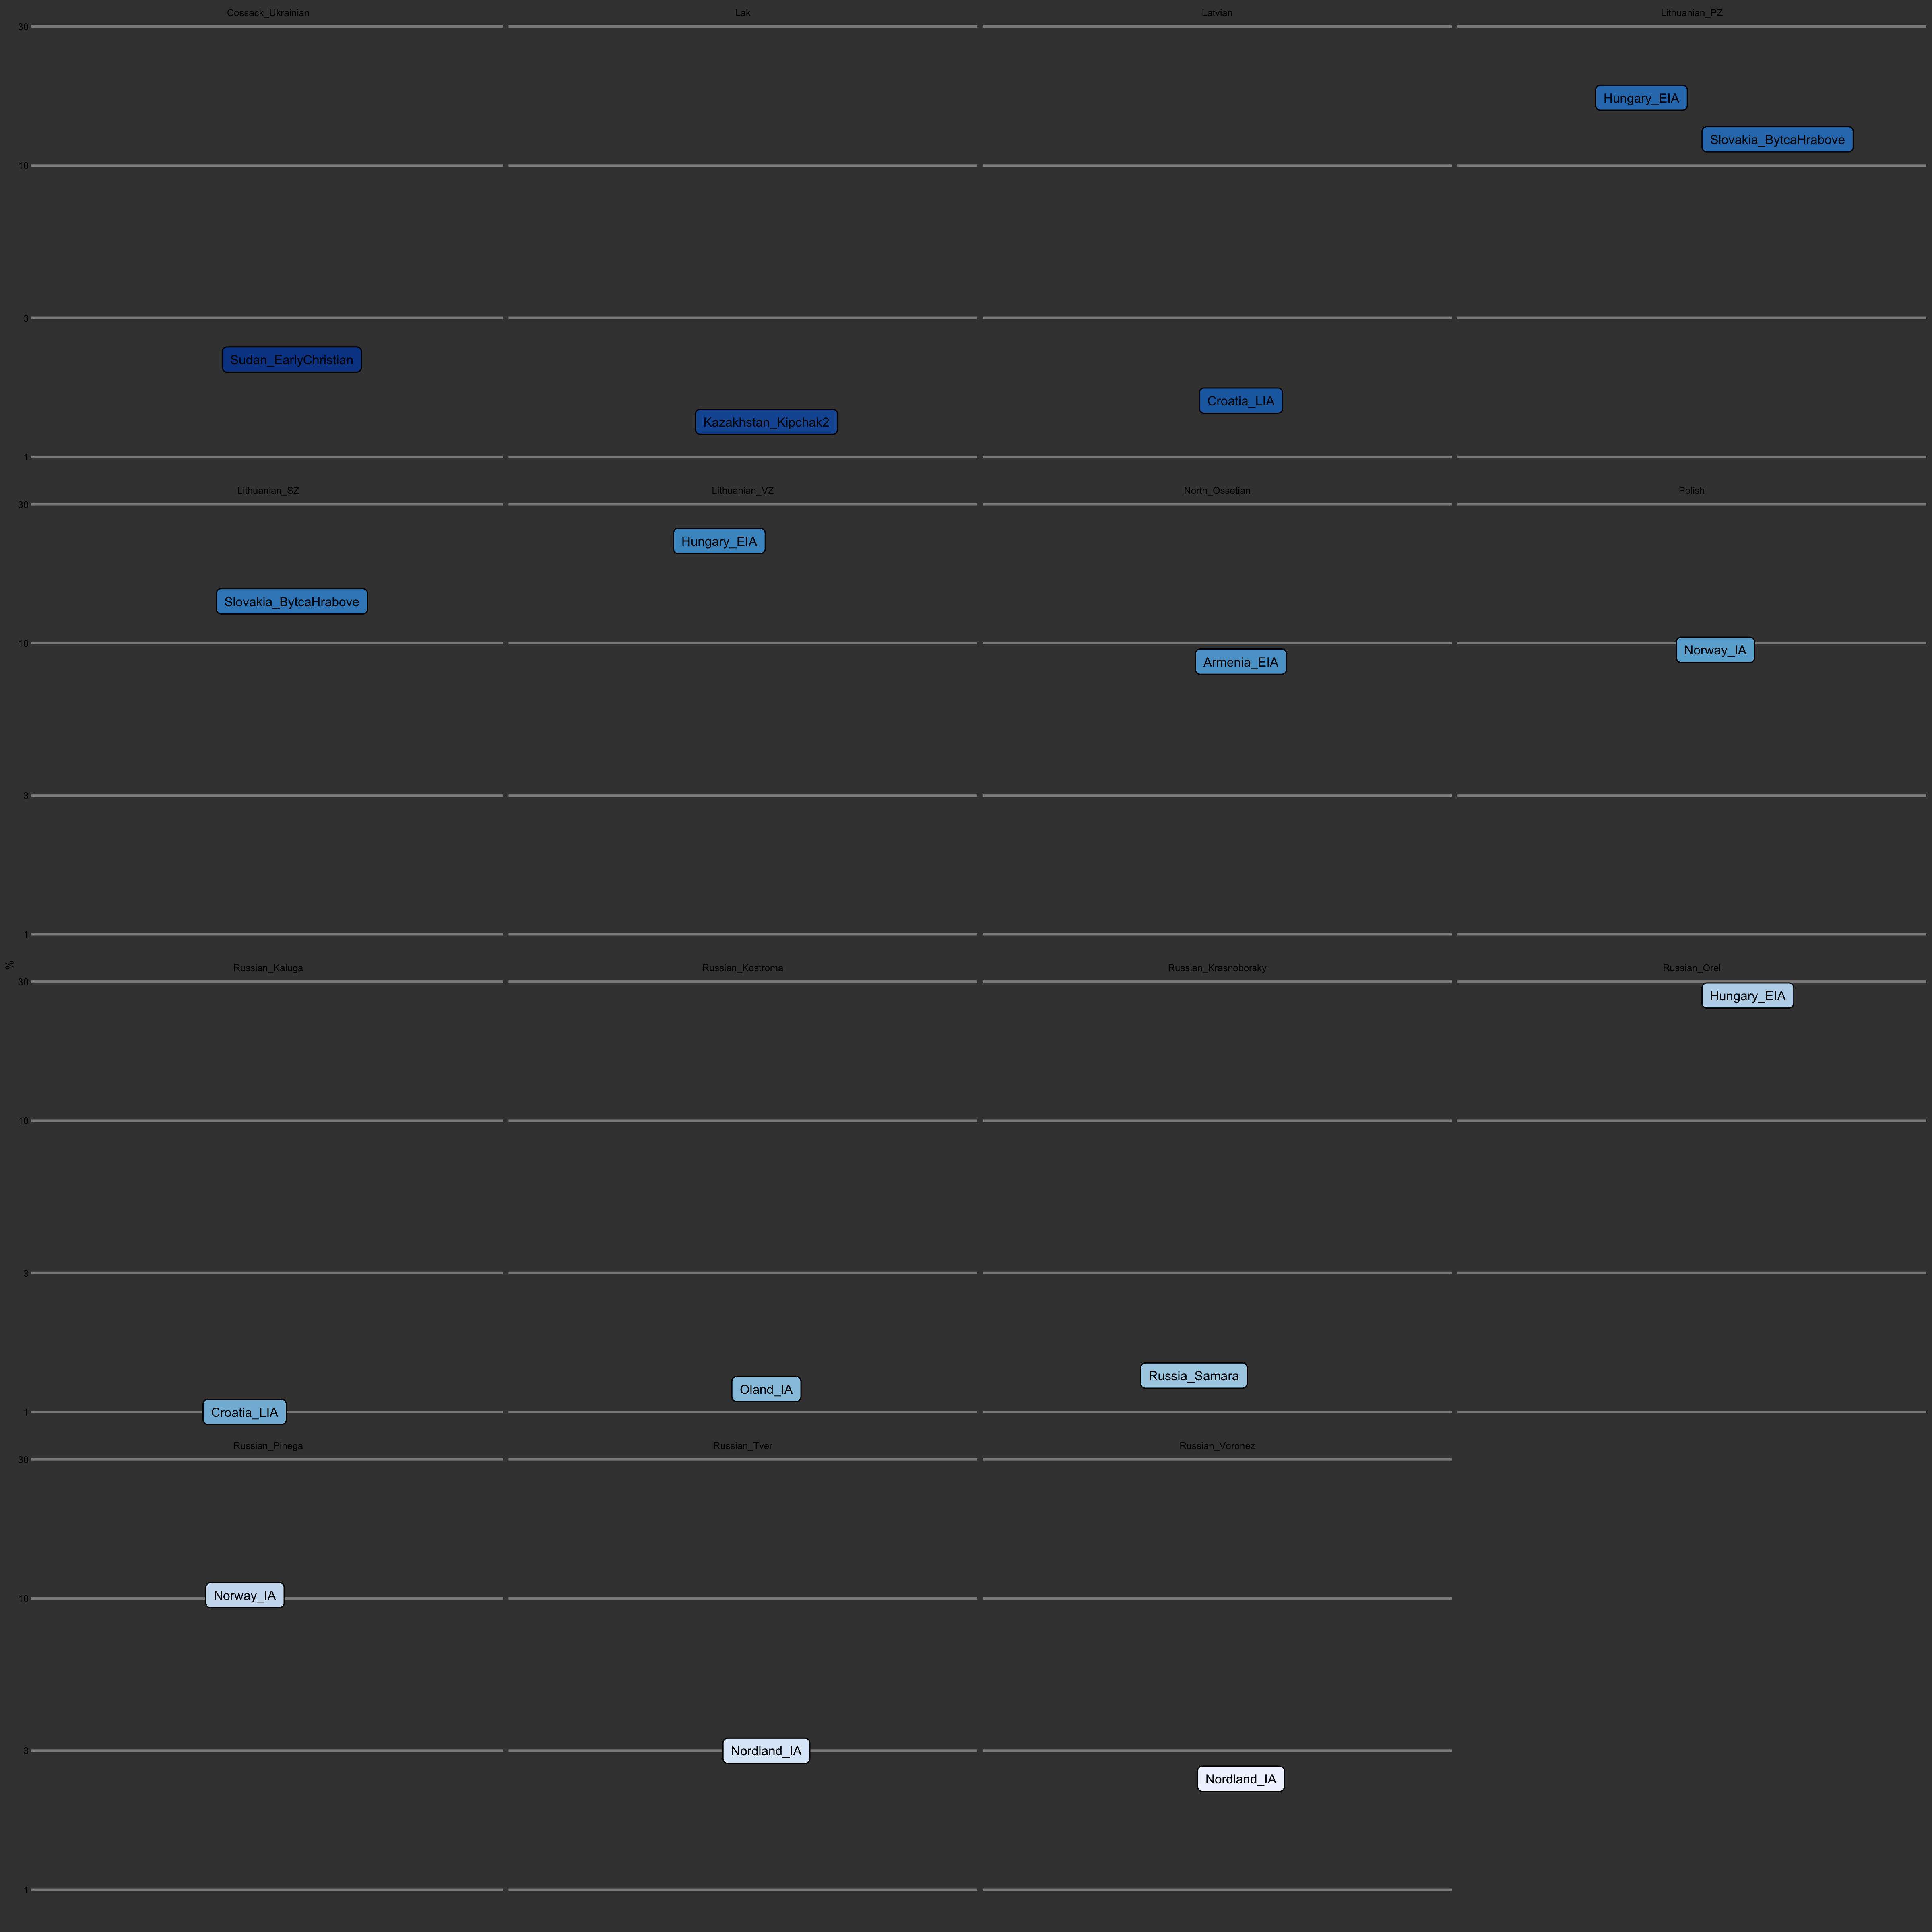

In [205]:
plotfun(mprd %>% sample_n(16),lsz = 2,nrw = 4)

Middle Ages

In [226]:
mdl = myfun(na.omit(mad),e = 1,a = 0,l = 15)

[1] "Number of classes: 131"
[1] "Split into test and train samples"
[1] 727  26
[1] 243  26
[1] "Starting XGBoost training"
[1]	train-mlogloss:4.236831	test-mlogloss:4.322459 
[26]	train-mlogloss:1.628838	test-mlogloss:3.342472 
[51]	train-mlogloss:1.043319	test-mlogloss:3.344535 
[76]	train-mlogloss:0.791594	test-mlogloss:3.397657 
[100]	train-mlogloss:0.663981	test-mlogloss:3.449302 
# A tibble: 15 × 5
     row label variable  value maxval
   <int> <dbl> <chr>     <dbl>  <dbl>
 1   192   110 119      0.156  0.156 
 2   125    57 57       0.0836 0.0836
 3   123    57 65       0.235  0.235 
 4    91    30 14       0.833  0.833 
 5   229   119 119      0.386  0.386 
 6    63    17 119      0.327  0.327 
 7   181   104 17       0.512  0.512 
 8   170    85 119      0.289  0.289 
 9   207   119 30       0.240  0.240 
10    12    11 74       0.159  0.159 
11   166    85 119      0.310  0.310 
12    41    14 14       0.988  0.988 
13   160    83 119      0.487  0.487 
14   155    75 13    

In [227]:
mprd = mypfun(mdl,mad,ppl)

[1] "Using 131 populations"


Joining with `by = join_by(variable)`


   name                       eth  value
1    MD Turkey_SoutheastByzantine  4.16%
2    MD           Turkey_Medieval  3.72%
3    MD         Syria_TellMasaikh  3.29%
4    MD          Portugal_Miroico  2.07%
5    MD               Italy_Lazio  10.6%
6    MN               Italy_Lazio 69.69%
7    RN               Italy_Lazio  59.3%
8    RN Turkey_SoutheastByzantine  2.44%
9    TP        Sweden_EarlyViking  8.12%
10   TP            Poland_Konskie 30.76%
11   TP           Poland_Balczewo  3.35%
12   TP            Denmark_Viking  2.41%
13   TP       Poland_Dziekanowice  2.21%


In [228]:
mprd = mypfun2(mdl,mad,ppl)

[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`


[1] "Using 131 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


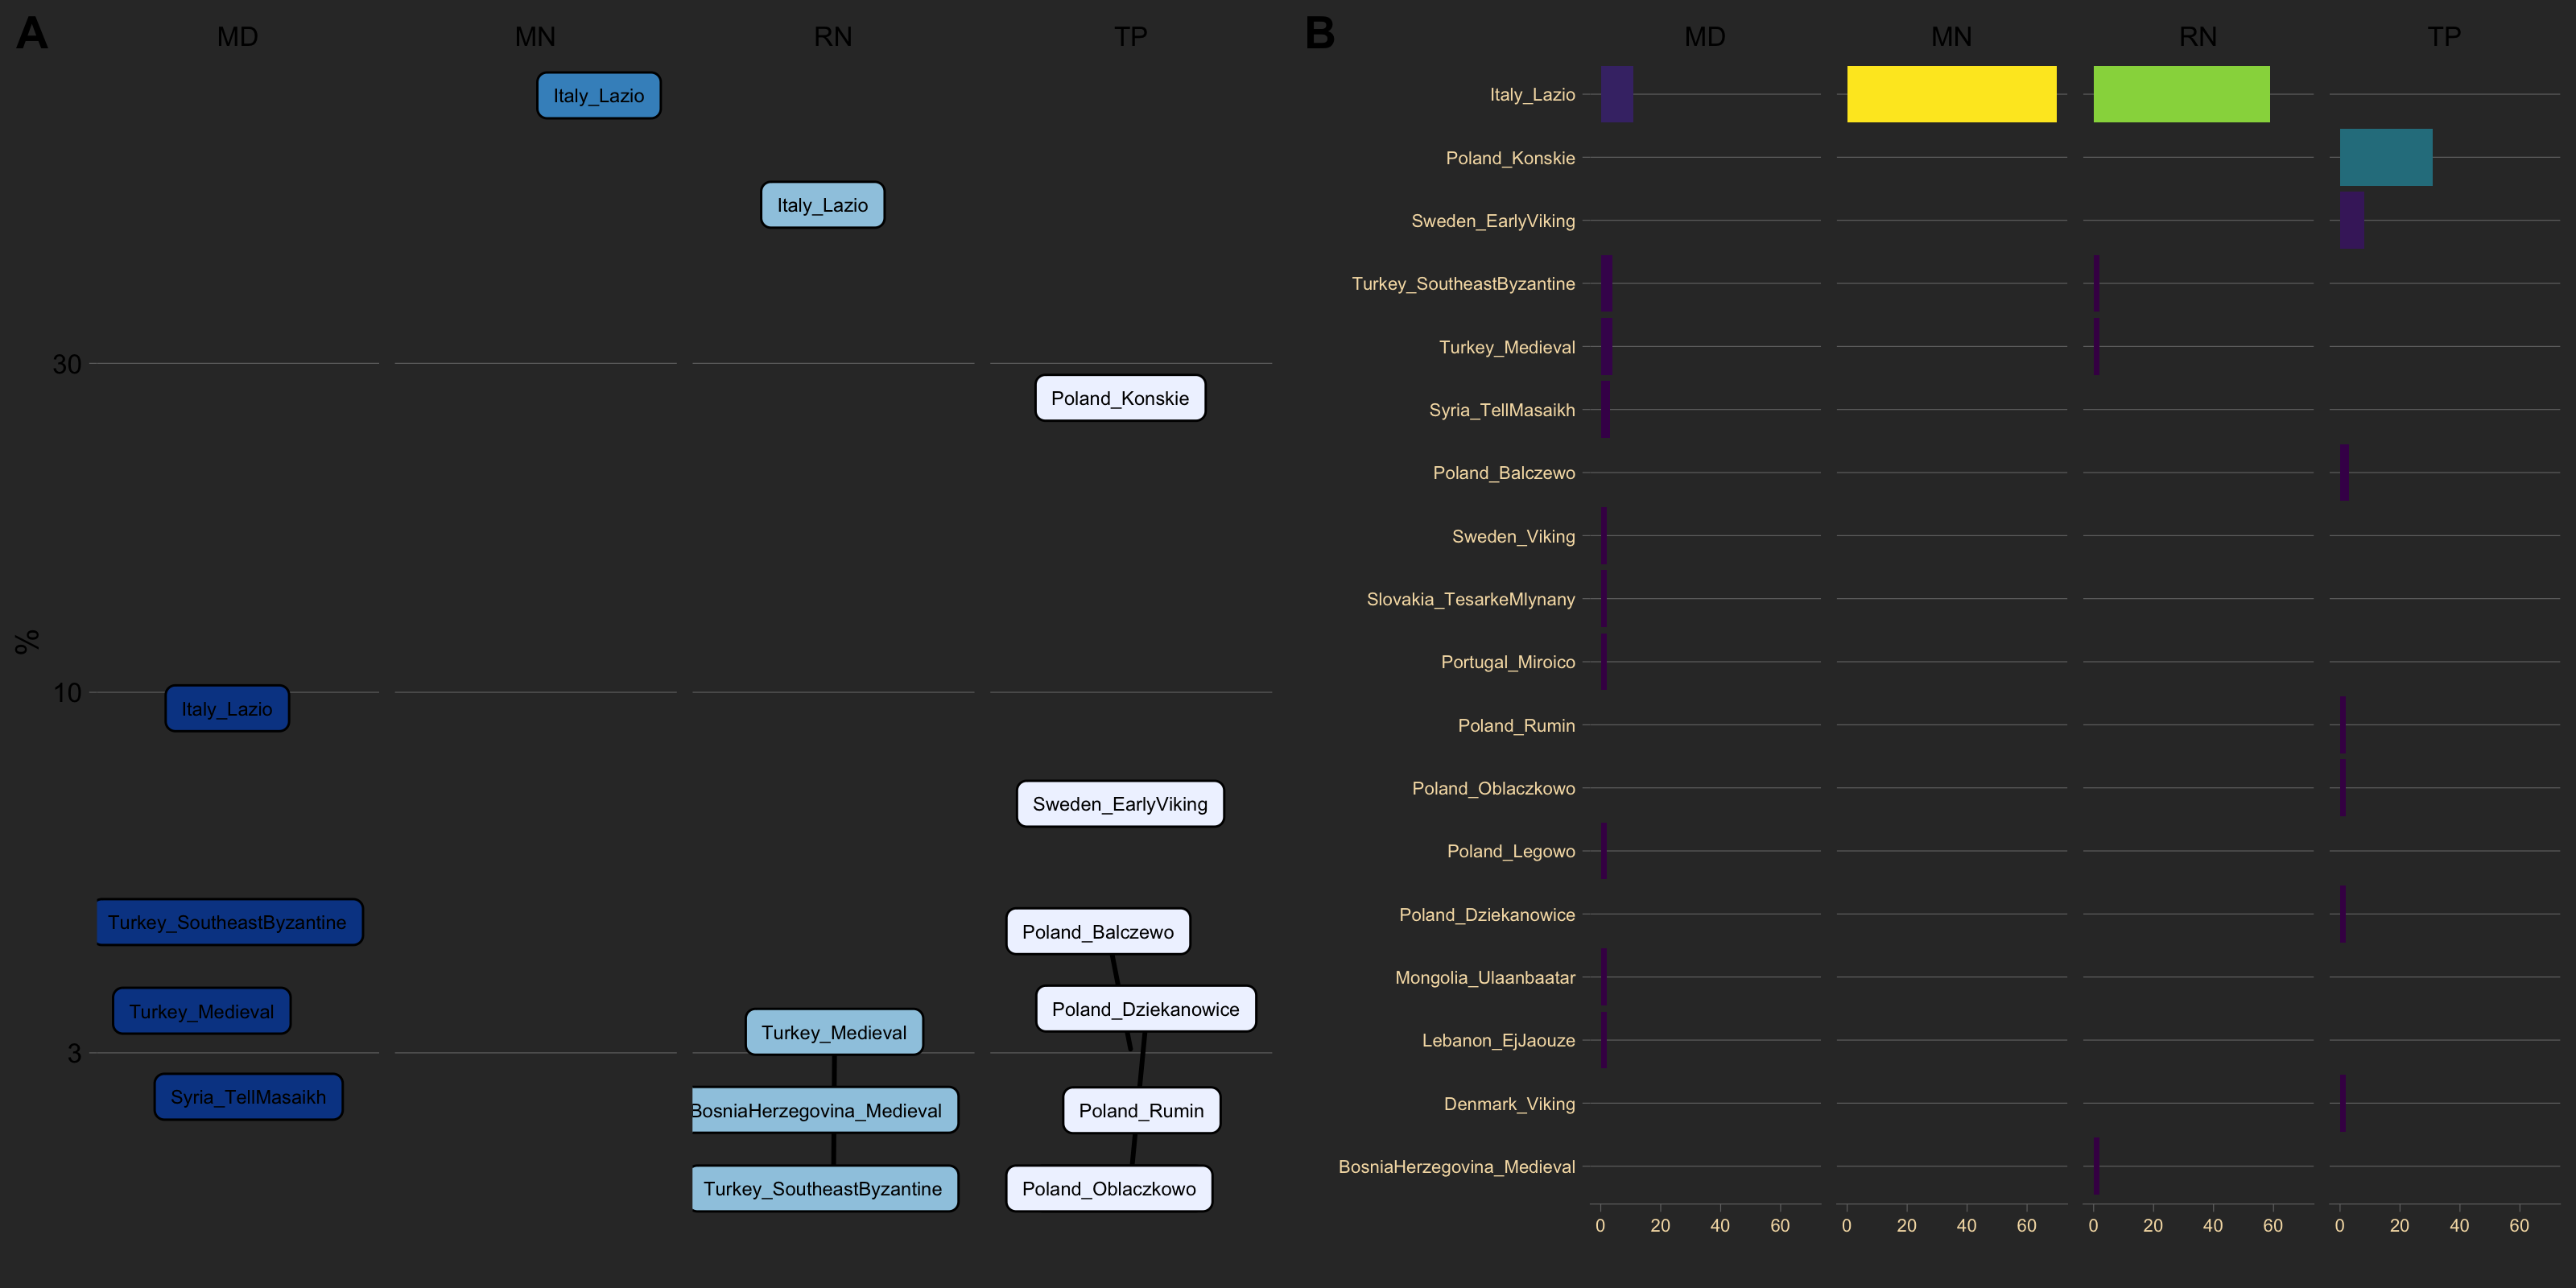

In [229]:
plotfun3(mprd)

In [93]:
mprd = mypfun(mdl,mad,smpls)

[1] "Using 163 populations"


Joining with `by = join_by(variable)`


                     name                           eth value
1    Ashkenazi_Belarussia                   Italy_Lazio 66.9%
2     Ashkenazi_Lithuania                   Italy_Lazio 51.7%
3     Ashkenazi_Lithuania               Kyrgyzstan_Saka  1.6%
4     Ashkenazi_Lithuania               Israel_Medieval  1.5%
5     Ashkenazi_Lithuania              Portugal_Miroico  1.1%
6     Ashkenazi_Lithuania    BosniaHerzegovina_Medieval    1%
7       Ashkenazi_Ukraine                   Italy_Lazio 51.2%
8       Ashkenazi_Ukraine               Kyrgyzstan_Saka  1.7%
9              Belarusian                Poland_Konskie    7%
10             Belarusian                 Poland_Milicz  6.4%
11             Belarusian            Sweden_EarlyViking  5.3%
12             Belarusian                Poland_Niemcza  3.6%
13             Belarusian                    Poland_Lad  3.3%
14             Belarusian             Poland_Oblaczkowo  3.3%
15             Belarusian               Poland_Balczewo  2.9%
16      

In [212]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 400)

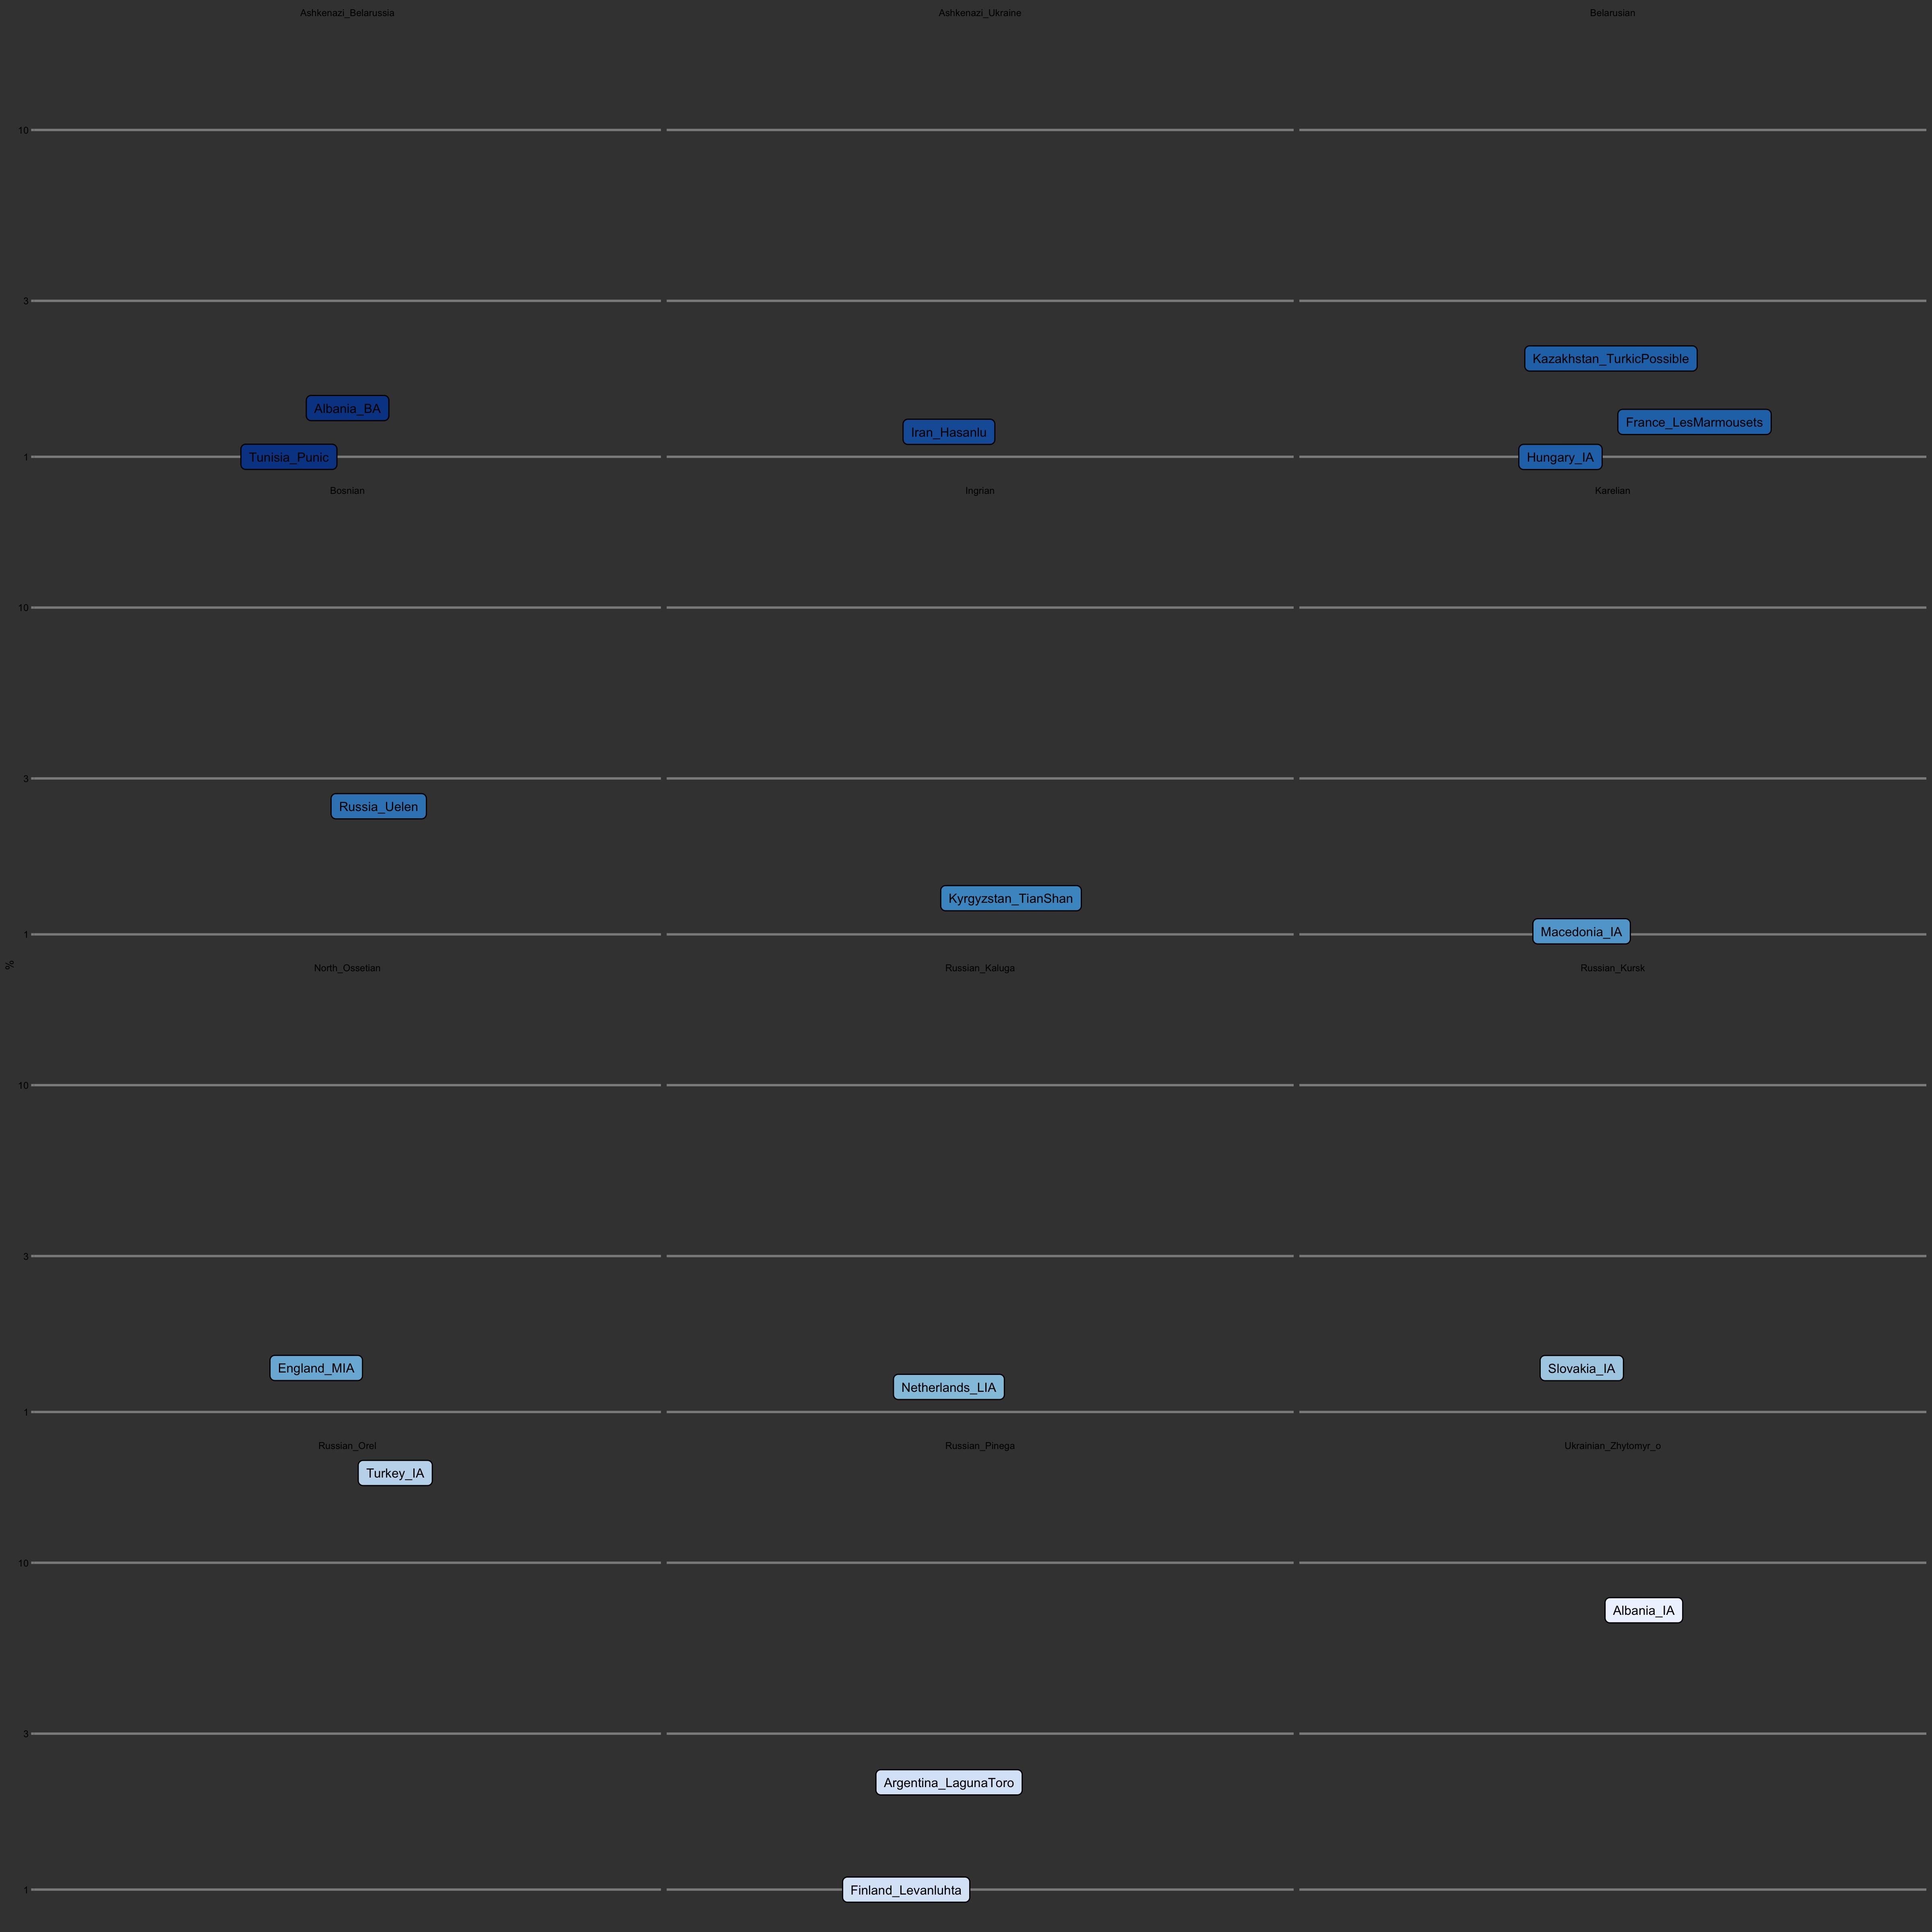

In [213]:
plotfun(mprd %>% sample_n(16),lsz = 2,nrw = 4)

Try extra metadata and retain

In [230]:
myd = as_tibble(import("../Raw Data/Archeological Samples/aDNA-Y-mt/all-ancient-dna.xlsx"))

Warning message:
“Expecting numeric in AA1070 / R1070C27: got '...'”
Warning message:
“Expecting numeric in AA1476 / R1476C27: got '...'”
Warning message:
“Expecting numeric in AA1477 / R1477C27: got '...'”
Warning message:
“Expecting numeric in AO2887 / R2887C41: got '..'”
Warning message:
“Expecting numeric in AA4167 / R4167C27: got '...'”
Warning message:
“Expecting numeric in AO5085 / R5085C41: got '..'”
Warning message:
“Coercing text to numeric in AO7537 / R7537C41: '0.088'”
Warning message:
“Expecting numeric in AO8135 / R8135C41: got '..'”
Warning message:
“Expecting numeric in AO8222 / R8222C41: got '..'”
Warning message:
“Expecting numeric in AO8246 / R8246C41: got '..'”
Warning message:
“Expecting numeric in AO11704 / R11704C41: got '..'”
Warning message:
“Expecting numeric in AO11886 / R11886C41: got '..'”
Warning message:
“Coercing text to numeric in AO14505 / R14505C41: '0.778'”


In [231]:
bad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_BA.csv"))
iad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_IA.csv"))
mad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_MA.csv"))

In [232]:
myd %>% sample_n(5)

Object-ID Colloquial-Skeletal       Latitude Longitude Sex mtDNA-coverage    
1 I1187     CHPKL301N-001             32.97417  35.33139 M   9.3800000000000008
2 Seden     NA                        62.10388 131.30859 NA  NA                
3 ECS1      NA                        47.14789  20.92393 NA  NA                
4 I0418     Kurgan 4, Grave 1, SVP 24 52.91278  50.99056 F   187               
5 HJTW13    ..                        33.59221 114.02212 M   7.4103399999999997
  mtFAR     mtDNA-haplogroup mtDNA-Haplotree
1 0.3246045 U6d              U6d            
2        NA NA               NA             
3 0.1696913 N1a              N1a            
4 0.2496144 T1a1             T1a1           
5        NA NA               NA             
  mt-FTDNA                                                          ⋯
1 https://www.familytreedna.com/public/mt-dna-haplotree/U;name=U6d  ⋯
2 NA                                                                ⋯
3 https://www.familytreedna.com/public/mt-dna-haplotree/N;name=N1a  ⋯
4 https://www.familytreedna.com/public/mt-dna-haplotree/T;name=T1a1 ⋯
5 NA                                                                ⋯
  Location                      SiteID  Country LP Skin Hair Eye P1104A Other
1 Peqi'in Cave                  NA      Israel  NA NA   NA   NA  NA     NA   
2 Central Yakutia               Seden   Russia  NA NA   NA   NA  NA     NA   
3 Ecsegfalva 1                  NA      Hungary NA NA   NA   NA  NA     NA   
4 Utyevka, Samara River, Samara Site IV Russia  NA NA   NA   NA  NA     NA   
5 HaoJiaTai                     NA      China   NA NA   NA   NA  NA     NA   
  Index
1  5620
2  1305
3   811
4  3008
5 12440

Only keep the sample IDs for G25 coordinates

In [233]:
myptrna = "(?<=:).+$"
myptrnb = "^\\w+?_\\w+?(?=[_:\\.])"
bad = bad %>% mutate(label = str_extract(sample,myptrnb),sample = str_extract(sample,myptrna),.before = V2)
iad = iad %>% mutate(label = str_extract(sample,myptrnb),sample = str_extract(sample,myptrna),.before = V2)
mad = mad %>% mutate(label = str_extract(sample,myptrnb),sample = str_extract(sample,myptrna),.before = V2)

In [234]:
mad %>% sample_n(5)

sample   label                   V2       V3        V4       V5       
1 VK435    Sweden_Viking           0.146832  0.137096 0.053551  0.033592
2 R2207.SG Slovakia_TesarkeMlynany 0.136588  0.135065 0.071276  0.041344
3 SHK002   Vladimir_MA             0.066017 -0.174671 0.042615 -0.000646
4 I20655   England_EarlyMedieval   0.127482  0.135065 0.075047  0.054264
5 VK352    Sweden_Viking           0.120652  0.124910 0.064111  0.064923
  V6        V7        V8        V9       ⋯ V17       V18       V19      
1  0.047393  0.015897 -0.000235 0.002077 ⋯ -0.015513  0.017863 -0.002660
2  0.032314  0.011156  0.001410 0.002077 ⋯ -0.001591 -0.007432  0.006081
3 -0.038469 -0.003347  0.007755 0.014769 ⋯  0.011403 -0.003260  0.003294
4  0.042162  0.021475  0.005170 0.006000 ⋯  0.022275  0.013038  0.001014
5  0.036930  0.016455  0.001410 0.009000 ⋯  0.008618 -0.004172  0.001647
  V20       V21      V22       V23       V24       V25      V26      
1  0.005656 0.026638  0.004991  0.008037  0.022061 0.005663  0.023471
2  0.006034 0.001876  0.013227  0.003462 -0.001849 0.015303  0.001197
3  0.010936 0.012006 -0.018467 -0.003586 -0.016885 0.002048 -0.000599
4 -0.002514 0.005503  0.011480 -0.003833  0.008381 0.014821 -0.008382
5  0.007290 0.004377  0.010606  0.001978  0.004560 0.005181 -0.004311

In [277]:
mydd = mad %>% left_join(myd,by = c("sample" = "Object-ID"))

In [272]:
mydd %>% sample_n(5) %>% select(sample,label,Simplified_Culture,Culture_Grouping,Label,Location,Country,Mean)

sample label                 Simplified_Culture Culture_Grouping
1 I17271 England_EarlyMedieval NA                 NA              
2 I16508 England_EarlyMedieval NA                 NA              
3 VK298  Denmark_Viking        Viking             Viking Denmark  
4 VK156  Poland_Viking         Viking             Viking Poland   
5 VK1    Greenland_EarlyNorse  Viking             Early_Norse     
  Label                   Location           Country   Mean
1 NA                      NA                 NA          NA
2 NA                      NA                 NA          NA
3 Denmark_Viking.SG       Sealand            Denmark    900
4 Poland_Viking.SG        Bodzia             Poland    1000
5 Greenland_EarlyNorse.SG Eastern Settlement Greenland 1000

In [240]:
mydd %>% count(Culture_Grouping,sort = TRUE)

Culture_Grouping           n  
1  NA                         414
2  Viking Sweden              118
3  Viking Denmark              68
4  Mongol                      49
5  Early_Viking                42
6  Viking UK                   28
7  Viking Norway               26
8  Viking Russia               26
9  Longobard Kingdom           20
10 Viking Iceland              16
11 Late Xiongnu                14
12 Medieval                    13
13 Early_Norse                 12
14 Uyghur                      11
15 Early Xiongnu               10
16 Anglo-Saxon Early Period     8
17 Anglo-Saxon Middle Period    8
18 Germany Medieval             7
19 Viking Poland                7
20 Lebanon Middle Ages          6
21 Türk                         6
22 North East Iberia Medieval   5
23 Fatyanovo Boshnevo           4
24 Guanche_mummy                4
25 Sardinia Medieval            4
26 Viking Ireland               4
27 Viking Orkney                4
28 Khitan                       3
29 Late_Norse                   3
30 Early Middle Ages            2
31 Muslim                       2
32 Viking Ukraine               2
33 "La Tène"                    1
34 Apulia Early Iron Age        1
35 Bavarian                     1
36 Bulgaria_EBA_EIA             1
37 Chilpek_800CE                1
38 Cis-Baikal Medieval          1
39 Heishui_Mohe_EarlyMedieval   1
40 High Middle Ages             1
41 Hungary Avar Late            1
42 Hungary Medieval             1
43 Kayalyk_950CE                1
44 Mongolia_LBA_Ulaanzukh       1
45 Old Bering Sea               1
46 Pict Orkney                  1
47 SE_Iberia_c.5-8CE            1
48 Saltovo-Mayaki               1
49 Sardinia_LateAntiquity       1
50 Slab Grave                   1
51 Turk                         1
52 Unclassified                 1
53 Ust'-Belaya medieval         1
54 Viking Faroes                1
55 Viking IsleOfMan             1
56 Viking Wales                 1

Optional time frame

In [283]:
mydd = mydd %>% dplyr::filter(Mean > 600,Mean < 1400)

Create class variable to label records by

In [278]:
mydd = mydd %>% 
        mutate(sample = ifelse(is.na(Location),label,paste(Culture_Grouping,Location,sep = "_"))) %>% 
        #mutate(sample = ifelse(is.na(Label),label,Label)) %>% #paste(Country,str_remove_all(Location,"[[:punct:]]"),sep = "_"))) %>% 
        mutate(sample = str_extract(sample,"^\\w{3,12}")) %>% 
        select(sample,all_of(matches("^V\\d")))

In [279]:
dim(mydd)
mydd %>% sample_n(5)

[1] 970  26

sample       V2       V3       V4       V5       V6       V7       V8       
1 Poland_Ostro 0.120652 0.119832 0.062602 0.066861 0.047086 0.015618  0.011516
2 Poland_Ostro 0.133173 0.123895 0.073539 0.077520 0.042469 0.018686  0.006110
3 Poland_Niemc 0.119514 0.123895 0.074293 0.066215 0.043700 0.053826  0.020916
4 Ireland_Kilt 0.133173 0.135065 0.056568 0.054910 0.035699 0.016455  0.002585
5 Viking       0.120652 0.128972 0.061848 0.049742 0.049240 0.016176 -0.000235
  V9       V10       ⋯ V17       V18       V19       V20       V21      
1 0.010615  0.000409 ⋯ -0.014187 -0.013169 -0.003294  0.006536 -0.006503
2 0.017307 -0.006340 ⋯  0.003713 -0.004172  0.004434  0.002137 -0.003126
3 0.011307 -0.021270 ⋯  0.004906  0.011735 -0.004434 -0.002640  0.001376
4 0.003461  0.003272 ⋯  0.016309  0.008866  0.004054 -0.007793  0.009755
5 0.003000  0.002863 ⋯ -0.003978 -0.020340  0.003801 -0.002891  0.006503
  V22       V23       V24       V25       V26      
1  0.000125 -0.007666  0.013064  0.007953  0.005628
2 -0.012977 -0.007296  0.013434 -0.006989  0.005987
3 -0.001248  0.003091  0.015899 -0.004338  0.021435
4  0.008859  0.002597  0.006162  0.012532  0.004670
5  0.008111 -0.000247 -0.001725  0.008194 -0.005987

In [280]:
mdl = myfun(na.omit(mydd),e = 1,a = 0,l = 15)

[1] "Number of classes: 155"
[1] "Split into test and train samples"
[1] 726  26
[1] 243  26
[1] "Starting XGBoost training"
[1]	train-mlogloss:3.875224	test-mlogloss:4.069648 
[26]	train-mlogloss:1.833329	test-mlogloss:2.962411 
[51]	train-mlogloss:1.288812	test-mlogloss:2.933635 
[76]	train-mlogloss:1.045214	test-mlogloss:2.947281 
[100]	train-mlogloss:0.912106	test-mlogloss:2.991623 
# A tibble: 15 × 5
     row label variable  value maxval
   <int> <dbl> <chr>     <dbl>  <dbl>
 1   119    92 47       0.0505 0.0505
 2    85    56 11       0.0799 0.0799
 3   220   153 153      0.832  0.832 
 4   236   154 153      0.244  0.244 
 5    97    37 37       0.0333 0.0333
 6     8   153 153      0.354  0.354 
 7   219   153 153      0.445  0.445 
 8   111    42 153      0.602  0.602 
 9   133   153 153      0.736  0.736 
10   224   144 145      0.129  0.129 
11   128    67 94       0.0353 0.0353
12   115    50 145      0.195  0.195 
13   194   135 153      0.467  0.467 
14    77    33 153   

In [281]:
mprd = mypfun(mdl,na.omit(mydd),ppl)

[1] "Using 155 populations"


Joining with `by = join_by(variable)`


   name          eth  value
1    MD  Uyghur_Olon  5.13%
2    MD Muslim_Plaza  2.73%
3    MD BosniaHerzeg  2.48%
4    MN  Uyghur_Olon  4.87%
5    MN    Longobard  2.96%
6    MN Chilpek_800C  2.61%
7    MN BosniaHerzeg   2.2%
8    MN Lebanon_Chhi  2.19%
9    MN        Early 19.68%
10   RN  Uyghur_Olon  4.05%
11   RN BosniaHerzeg  3.39%
12   RN Lebanon_Chhi  2.97%
13   TP Uppland_Late  9.94%
14   TP Poland_Marko  6.94%
15   TP Late_Norse_W  5.51%
16   TP Poland_Niemc   4.9%
17   TP Poland_Plons  3.45%
18   TP  Italy_Lazio  2.67%
19   TP Poland_Rumin  2.29%


In [282]:
mprd = mypfun2(mdl,na.omit(mydd),ppl)

[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`


[1] "Using 155 populations"


Joining with `by = join_by(variable)`
`summarise()` has grouped output by 'name'. You can override using the
`.groups` argument.


Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


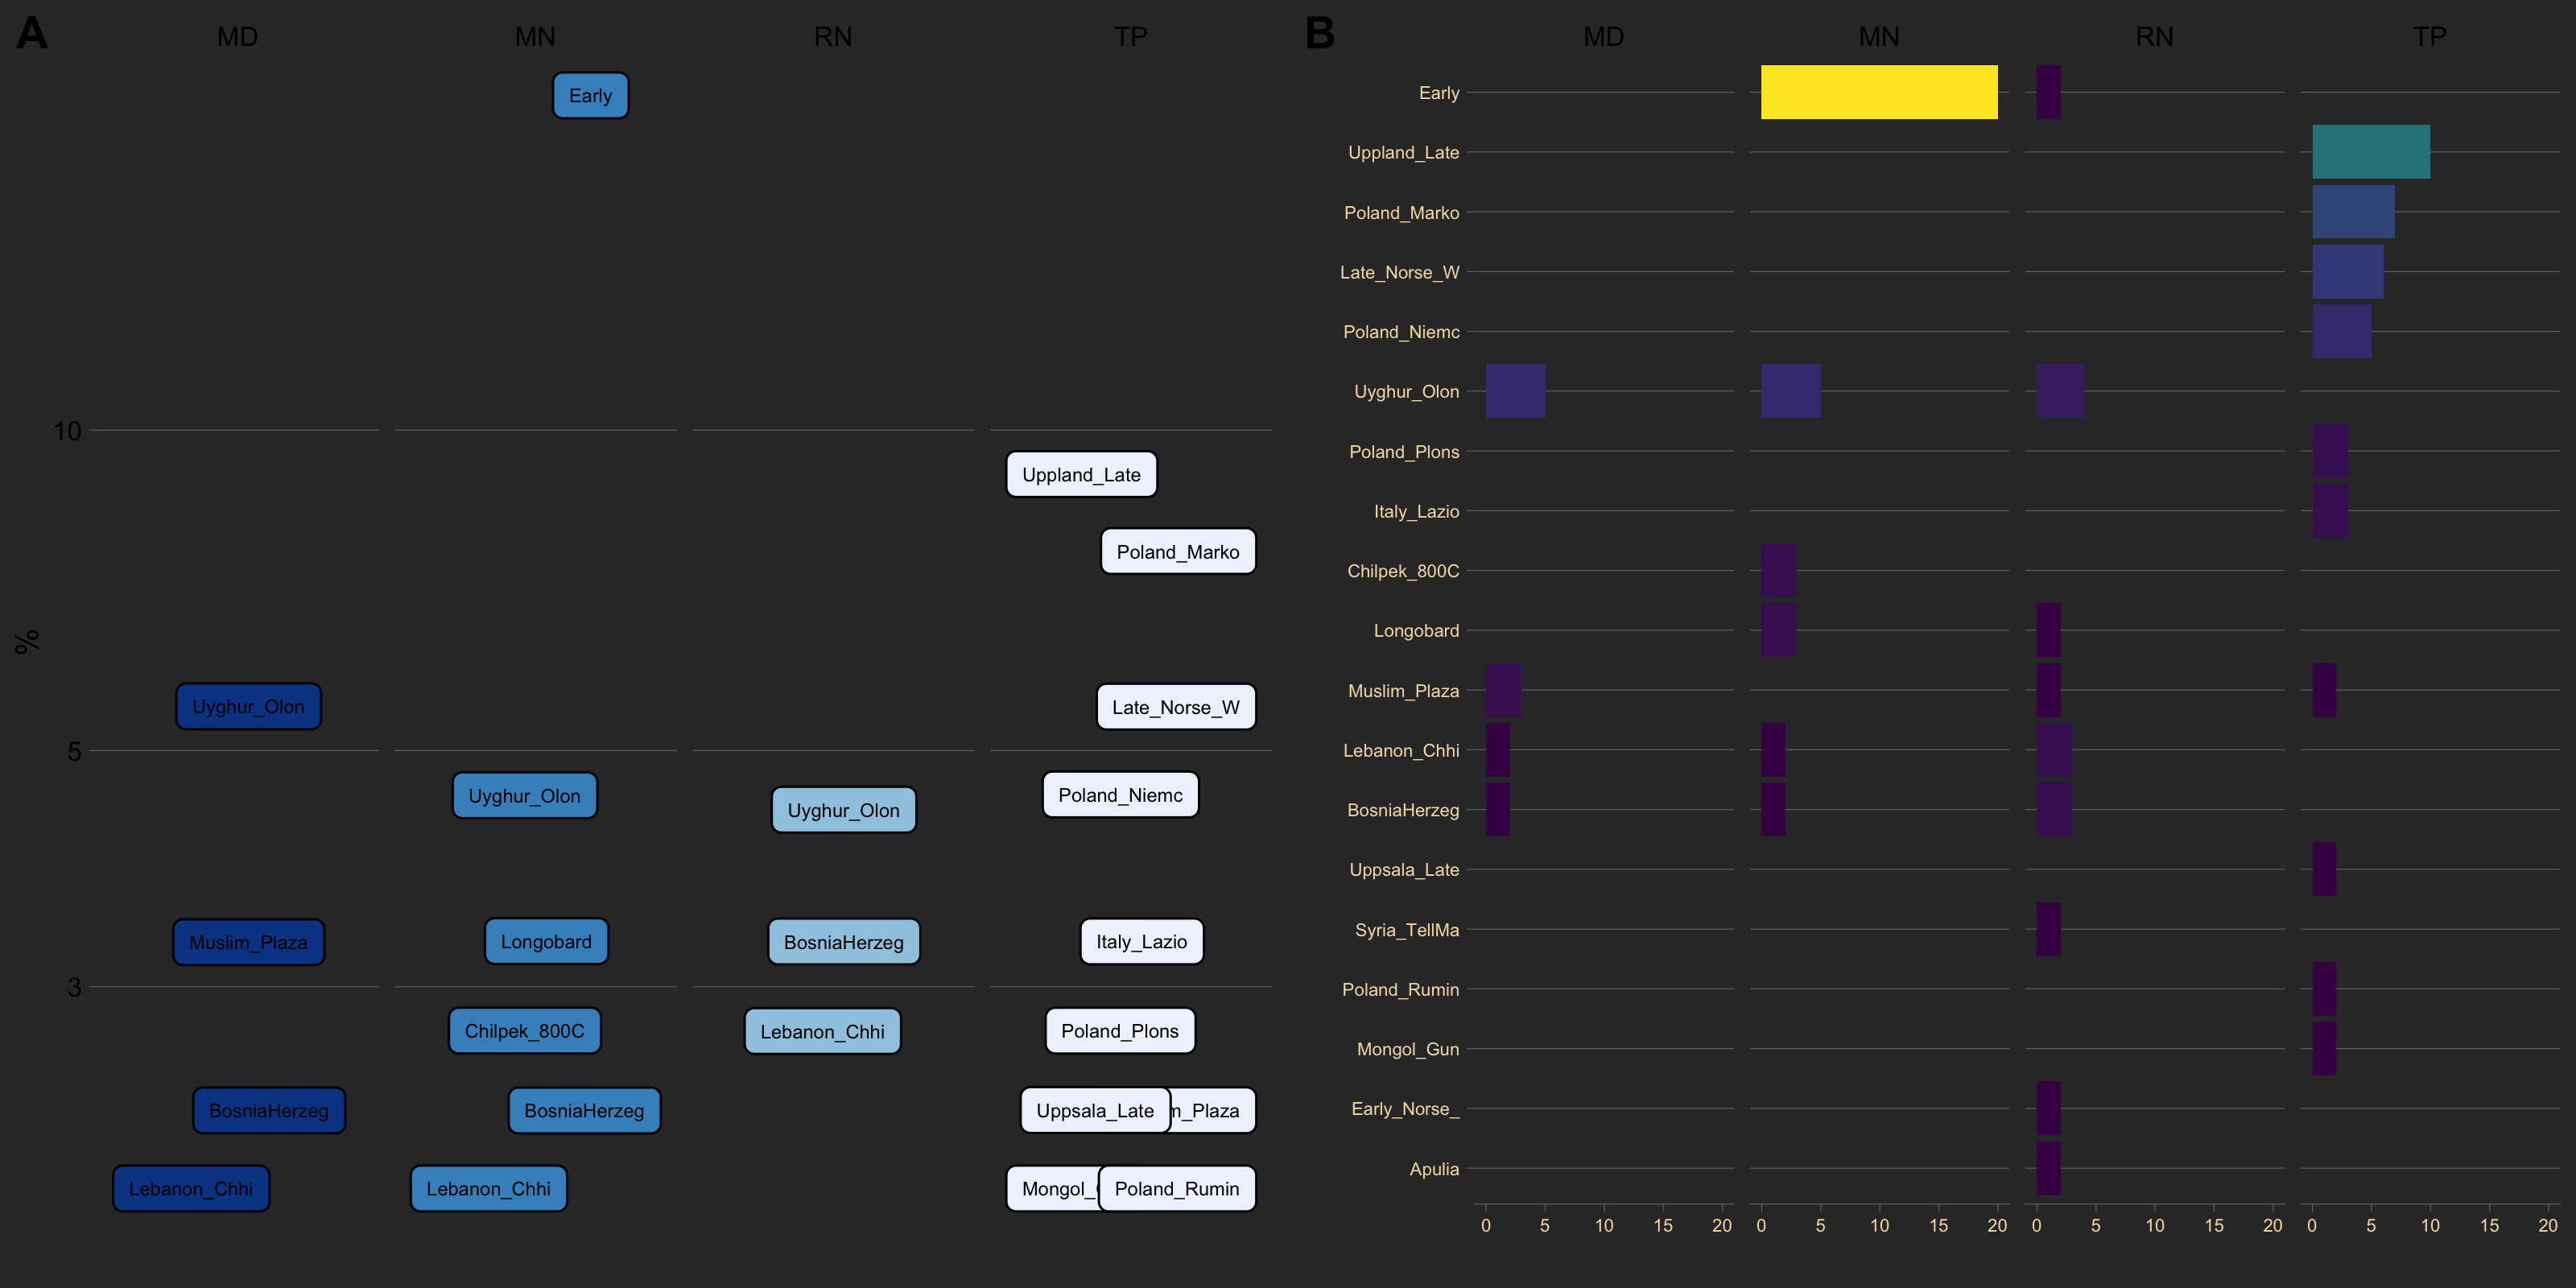

In [283]:
plotfun3(mprd)